# 0. Imports

## 0.1. Libraries and configs

In [88]:
# Built-in
from dataclasses import dataclass
from datetime import datetime
from glob import glob
import os
from sys import path
path.append(os.path.join(".."))
from typing import Any, Dict, List, Optional

# Installed
from inflection import underscore
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import joblib
from boruta import BorutaPy
from sklearn.model_selection import train_test_split, cross_validate
from sklearn import preprocessing as pp
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor, HistGradientBoostingRegressor, StackingRegressor
from sklearn import metrics as m
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from hyperopt import STATUS_OK, Trials, hp, tpe, fmin
import mlflow
from mlflow.tracking import MlflowClient
from mlflow.exceptions import MlflowException

# Custom
from src.utils import set_jupyter_settings
set_jupyter_settings(filterwarnings=True)
from src.database.data_ingestion import ingest_data_into_database
from src.__logs__.logging import logger

[03/08/23 10:29:18] INFO     Jupyter has been successfully configured.                                  ]8;id=441001;file:///home/sheep/documents/repos/predict-taxi-tip-amount/notebooks/../src/utils.py\utils.py]8;;\:]8;id=42450;file:///home/sheep/documents/repos/predict-taxi-tip-amount/notebooks/../src/utils.py#57\57]8;;\

In [74]:
# Database
CONNECTION_STRING: str | None = os.getenv("CONNECTION_STRING")

# Folder paths
DATA_DIR: str = os.path.join("..", "data")
CHECKPOINT_DIR: str = os.path.join(DATA_DIR, "interim", "cleaned_train_data.parquet")
PREPROCESSORS_DIR: str = os.path.join("..", "src", "pipeline", "preprocessors")
MODELS_DIR: str = os.path.join("..", "models")
REPORTS_DIR: str = os.path.join("..", "reports")

# MLflow
EXPERIMENT_NAME: str = "Experiment_02"
MLFLOW_TRACKING_URI: str = "http://127.0.0.1:5000"
ARTIFACT_DIR: str = "models"

## 0.2. Data acquisition
Data source: [TLC Trip Record Data](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page)

In [3]:
# Although the data is already hosted and freely available on the internet,
# I'm still loading it into a dockerized database to practice integrations.
ingest_data_into_database(
    connection_string=CONNECTION_STRING,
    data_directory=DATA_DIR,
    files=[
        "green_tripdata_2022-01.parquet",
        "green_tripdata_2022-02.parquet",
    ]
)

[03/08/23 09:25:02] INFO     Ingesting 131894 records into the database...                     ]8;id=499748;file:///home/sheep/documents/repos/predict-taxi-tip-amount/notebooks/../src/database/data_ingestion.py\data_ingestion.py]8;;\:]8;id=375441;file:///home/sheep/documents/repos/predict-taxi-tip-amount/notebooks/../src/database/data_ingestion.py#25\25]8;;\

[03/08/23 09:25:21] INFO     Data ingestion completed.                                         ]8;id=146039;file:///home/sheep/documents/repos/predict-taxi-tip-amount/notebooks/../src/database/data_ingestion.py\data_ingestion.py]8;;\:]8;id=295528;file:///home/sheep/documents/repos/predict-taxi-tip-amount/notebooks/../src/database/data_ingestion.py#42\42]8;;\

In [4]:
raw_data: pd.DataFrame = pd.read_sql("SELECT * FROM green_taxi", CONNECTION_STRING)
raw_data.sample(3)

,id,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
105617,105618,2,2022-02-20 11:29:23,2022-02-20 11:45:01,N,1.0,196,173,1.0,1.83,11.5,0.0,0.5,0.00,0.0,None,0.3,12.30,2.0,1.0,0.0
83188,83189,2,2022-02-10 14:14:15,2022-02-10 14:25:47,N,1.0,75,166,1.0,1.76,9.5,0.0,0.5,2.58,0.0,None,0.3,12.88,1.0,1.0,0.0
72941,72942,2,2022-02-05 16:37:49,2022-02-05 16:59:11,N,5.0,82,82,1.0,2.71,15.0,0.0,0.0,0.00,0.0,None,0.3,15.30,2.0,2.0,0.0


# 1. Data cleansing and description

## Data dictionary
Link: [Data dictionary trip records green](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_green.pdf)

## 1.1. Rename columns

In [5]:
raw_data.columns = [underscore(column) for column in raw_data.columns]

## 1.2. Data dimensions

In [6]:
print(
    f"""
    Number of columns: {raw_data.shape[1]}
    Number of rows: {raw_data.shape[0]:,}
    """
)


    Number of columns: 21
    Number of rows: 131,894
    


## 1.3. Duplicate data

In [7]:
raw_data.duplicated().sum()

0

## 1.4. Data types

In [8]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131894 entries, 0 to 131893
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   id                     131894 non-null  int64         
 1   vendor_id              131894 non-null  object        
 2   lpep_pickup_datetime   131894 non-null  datetime64[ns]
 3   lpep_dropoff_datetime  131894 non-null  datetime64[ns]
 4   store_and_fwd_flag     118178 non-null  object        
 5   ratecode_id            118178 non-null  object        
 6   pu_location_id         131894 non-null  object        
 7   do_location_id         131894 non-null  object        
 8   passenger_count        118178 non-null  float64       
 9   trip_distance          131894 non-null  float64       
 10  fare_amount            131894 non-null  float64       
 11  extra                  131894 non-null  float64       
 12  mta_tax                131894 non-null  floa

## 1.5. Missing data

In [9]:
raw_data.isna().sum()

id                            0
vendor_id                     0
lpep_pickup_datetime          0
lpep_dropoff_datetime         0
store_and_fwd_flag        13716
ratecode_id               13716
pu_location_id                0
do_location_id                0
passenger_count           13716
trip_distance                 0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
ehail_fee                131894
improvement_surcharge         0
total_amount                  0
payment_type              13716
trip_type                 13716
congestion_surcharge      13716
dtype: int64

In [11]:
# Maybe columns with NAs are related
raw_data.loc[raw_data.loc[:, "payment_type"].isna(), :] \
    .equals(raw_data.loc[raw_data.loc[:, "ratecode_id"].isna(), :])

True

In [15]:
columns_with_null_values: List[str] = [
    "store_and_fwd_flag", "passenger_count", "ratecode_id",
    "payment_type", "trip_type", "congestion_surcharge"
]
# Null values are indeed related. They're all in the same rows
print(len(raw_data.dropna(subset=columns_with_null_values, axis=0)) == len(raw_data) - 13_716)

True


In [20]:
raw_data.loc[raw_data.loc[:, "ratecode_id"].isna(), :]

,id,vendor_id,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,ratecode_id,pu_location_id,do_location_id,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
56200,56201,1,2022-01-01 00:50:14,2022-01-01 01:12:08,None,None,255,158,NaN,4.40,18.50,0.5,0.5,2.26,0.00,None,0.3,24.81,None,None,NaN
56201,56202,2,2022-01-01 00:18:00,2022-01-01 00:36:00,None,None,112,40,NaN,4.20,26.59,0.0,0.0,5.98,0.00,None,0.3,32.87,None,None,NaN
56202,56203,2,2022-01-01 00:47:00,2022-01-01 01:06:00,None,None,223,244,NaN,6.75,23.38,0.0,0.0,6.58,6.55,None,0.3,36.81,None,None,NaN
56203,56204,2,2022-01-01 00:54:00,2022-01-01 01:08:00,None,None,80,33,NaN,3.98,16.63,0.0,0.0,1.88,0.00,None,0.3,18.81,None,None,NaN
56204,56205,2,2022-01-01 00:41:00,2022-01-01 01:04:00,None,None,189,4,NaN,5.08,22.70,0.0,0.0,5.67,0.00,None,0.3,31.42,None,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131889,131890,2,2022-02-28 23:27:00,2022-02-28 23:38:00,None,None,65,87,NaN,2.61,13.60,0.0,0.0,3.66,0.00,None,0.3,20.31,None,None,NaN
131890,131891,2,2022-02-28 23:59:00,2022-03-01 00:10:00,None,None,97,231,NaN,2.88,12.07,0.0,0.0,3.00,0.00,None,0.3,18.12,None,None,NaN
131891,131892,2,2022-02-28 23:18:00,2022-02-28 23:27:00,None,None,74,116,NaN,2.22,10.68,0.0,0.0,1.22,0.00,None,0.3,12.20,None,None,NaN
131892,131893,2,2022-02-28 23:31:00,2022-02-28 23:39:00,None,None,42,69,NaN,1.59,8.88,0.0,0.0,0.00,0.00,None,0.3,9.18,None,None,NaN


In [21]:
# As these rows are all related, I'm assuming it was a problem when saving this data.
# That's why I'm just dropping these "problematic" rows.
raw_data.dropna(subset=columns_with_null_values, axis=0, inplace=True)

## 1.6. Outliers

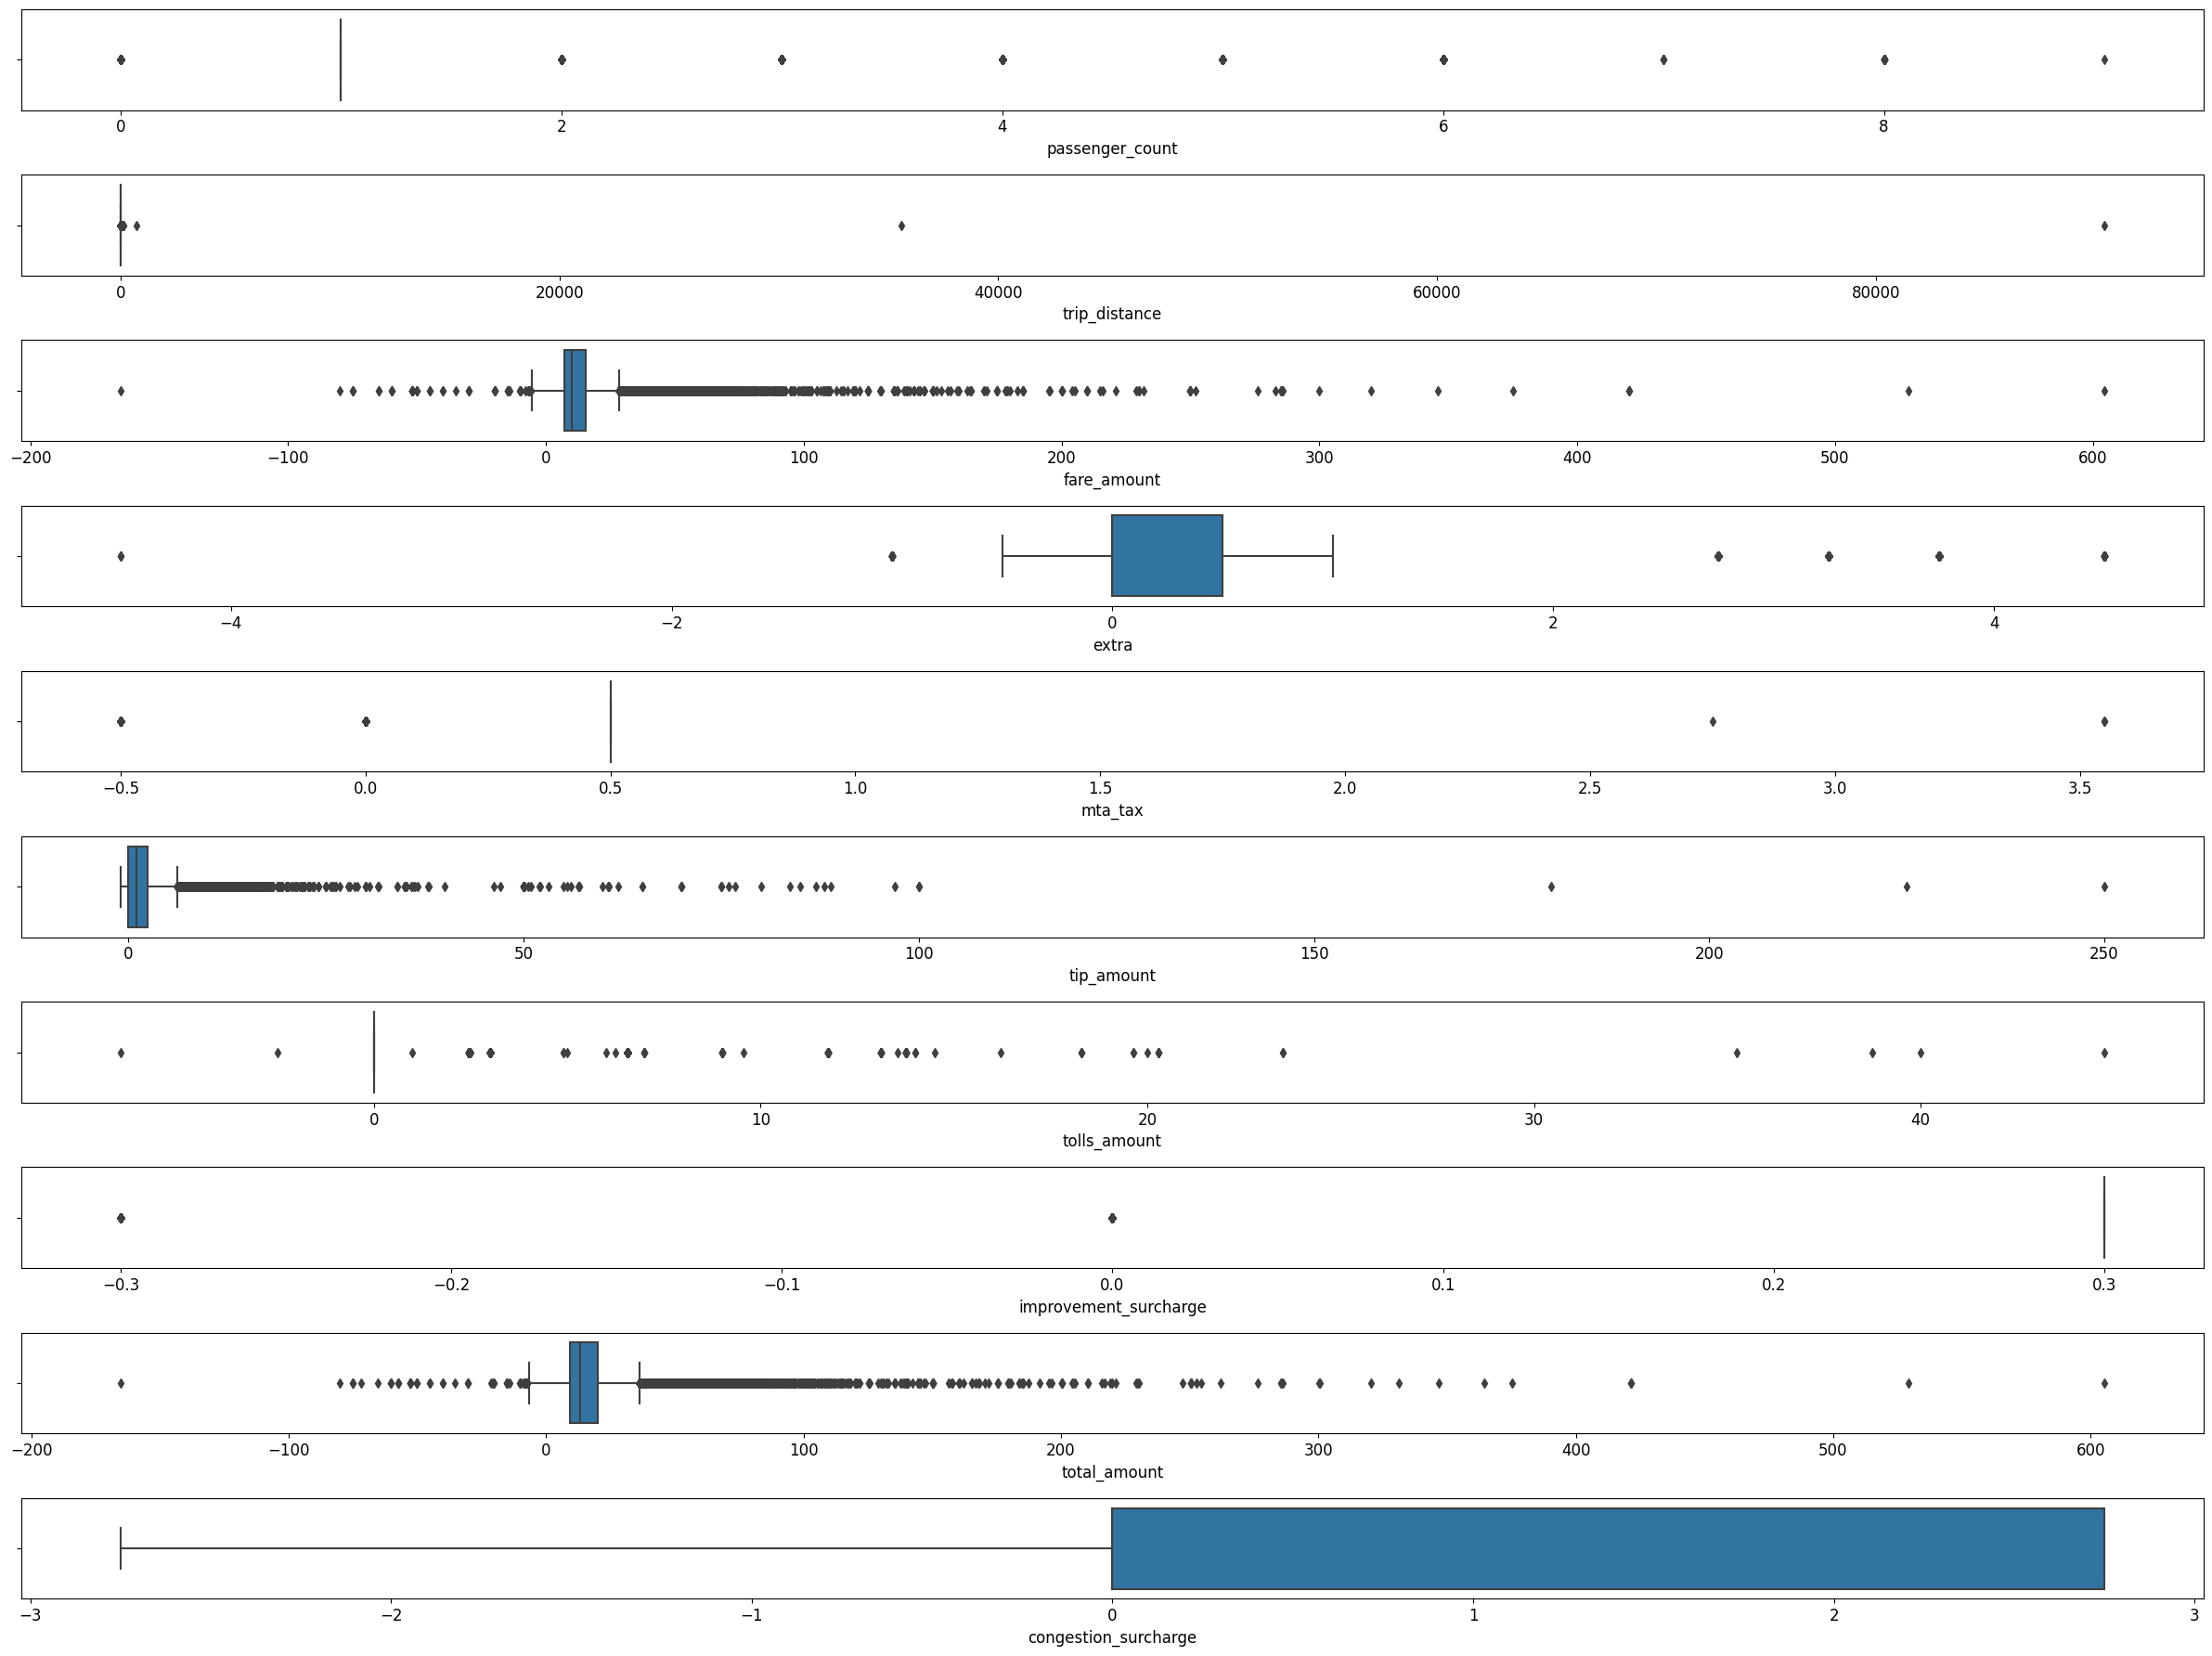

In [22]:
might_have_outlier_columns: List[str] = [
    "passenger_count", "trip_distance", "fare_amount",
    "extra", "mta_tax", "tip_amount", "tolls_amount",
    "improvement_surcharge", "total_amount", "congestion_surcharge"
]
_, ax = plt.subplots(
    nrows=len(might_have_outlier_columns),
    ncols=1,
    figsize=(24,18)
)
for idx, column in enumerate(might_have_outlier_columns):
    sns.boxplot(x=column, data=raw_data, ax=ax[idx]);
    plt.tight_layout()

In [23]:
print(f"Before: {len(raw_data):,}")
for column in might_have_outlier_columns:
    q75, q25 = np.percentile(raw_data.loc[:, column], 75), np.percentile(raw_data.loc[:, column], 25)
    iqr: float = q75 - q25
    cut_off: float = 3.0 * iqr
    lower, upper = q25 - cut_off, q75 + cut_off
    mask: List[bool] = [False if x < lower or x > upper else True for x in raw_data.loc[:, column]]
    raw_data: pd.DataFrame = raw_data.loc[mask, :]
print(f"After: {len(raw_data):,}")

Before: 118,178
After: 66,953


## 1.7. Descriptive statistics

In [24]:
numerical_attributes: pd.DataFrame = raw_data.select_dtypes(include=["int", "float"])
categorical_attributes: pd.DataFrame = raw_data.select_dtypes(include=["object", "category"])

### 1.7.1. Numerical attributes

In [25]:
# Calculate central tendency and dispersion metrics
numerical_attributes_description = pd.DataFrame({
    "Mean": numerical_attributes.apply(np.mean),
    "Median": numerical_attributes.apply(np.median),
    "Std. deviation": numerical_attributes.apply(np.std),
    "Min": numerical_attributes.apply(np.min),
    "Max": numerical_attributes.apply(np.max),
    "Range": numerical_attributes.apply(lambda x: np.max(x) - np.min(x)),
    "Skew": numerical_attributes.apply(lambda x: x.skew()),
    "Kurtosis": numerical_attributes.apply(lambda x: x.kurtosis())
})
numerical_attributes_description

,Mean,Median,Std. deviation,Min,Max,Range,Skew,Kurtosis
id,62041.573372,64987.00,3.667594e+04,1.0,124472.00,124471.00,-0.003114,-1.275775
passenger_count,1.000000,1.00,0.000000e+00,1.0,1.00,0.00,0.000000,0.000000
trip_distance,1.898339,1.46,1.574303e+00,0.0,9.67,9.67,1.879188,4.284090
fare_amount,10.081907,8.50,5.781056e+00,0.0,39.00,39.00,1.677388,3.316899
extra,0.299008,0.00,4.083383e-01,0.0,1.00,1.00,0.857927,-0.960646
mta_tax,0.500000,0.50,0.000000e+00,0.5,0.50,0.00,0.000000,0.000000
tip_amount,1.033623,0.00,1.367699e+00,0.0,9.39,9.39,1.397091,2.101903
tolls_amount,0.000000,0.00,0.000000e+00,0.0,0.00,0.00,0.000000,0.000000
improvement_surcharge,0.300000,0.30,1.110223e-16,0.3,0.30,0.00,0.000000,0.000000
total_amount,12.215091,10.56,6.101119e+00,0.8,45.36,44.56,1.469663,2.512480


### 1.7.2. Categorical attributes

In [26]:
categorical_attributes.describe().T

,count,unique,top,freq
vendor_id,66953,2,2,55804
store_and_fwd_flag,66953,2,N,66226
ratecode_id,66953,5,1.0,66812
pu_location_id,66953,197,74,11554
do_location_id,66953,231,74,5448
ehail_fee,0,0,NaN,NaN
payment_type,66953,5,1.0,37314
trip_type,66953,2,1.0,66938


# 2. Feature engineering

## 2.1. Phenomenon modeling

In [27]:
# Create new columns using the shorthand pandas function "assign"
raw_data: pd.DataFrame = raw_data.assign(
    trip_duration=(
        raw_data.loc[:, "lpep_dropoff_datetime"] - raw_data.loc[:, "lpep_pickup_datetime"]
    ).dt.seconds / 60,
    pickup_second=(
        raw_data.loc[:, "lpep_pickup_datetime"].dt.second
    ),
    pickup_minute=(
        raw_data.loc[:, "lpep_pickup_datetime"].dt.minute
    ),
    pickup_hour=(
        raw_data.loc[:, "lpep_pickup_datetime"].dt.hour
    ),
    dropoff_second=(
        raw_data.loc[:, "lpep_dropoff_datetime"].dt.second
    ),
    dropoff_minute=(
        raw_data.loc[:, "lpep_dropoff_datetime"].dt.minute
    ),
    dropoff_hour=(
        raw_data.loc[:, "lpep_dropoff_datetime"].dt.hour
    ),
    dropoff_day=(
        raw_data.loc[:, "lpep_dropoff_datetime"].dt.day
    ),
    dropoff_week=(
        raw_data.loc[:, "lpep_dropoff_datetime"].dt.week
    ),
    dropoff_weekofyear=(
        raw_data.loc[:, "lpep_dropoff_datetime"].dt.weekofyear
    ),
    location_id=(
        raw_data.loc[:, "pu_location_id"] + raw_data.loc[:, "do_location_id"]
    ),
    price_per_meter=(
        raw_data.loc[:, "trip_distance"] / (raw_data.loc[:, "fare_amount"] + 0.1)
    ),
    tax_per_meter=(
        raw_data.loc[:, "trip_distance"] * raw_data.loc[:, "mta_tax"]
    ),
)

## 2.2. Filtering

In [28]:
irrelevant_columns_to_drop: List[str] = [
    "ehail_fee", "passenger_count", "tolls_amount",
    "improvement_surcharge", "congestion_surcharge"
]
raw_data.drop(irrelevant_columns_to_drop, axis=1, inplace=True)

In [29]:
# raw_data = raw_data.loc[(raw_data.loc[:, "trip_duration"] >= 1) & (raw_data.loc[:, "trip_duration"] <= 60), :]

## Checkpoint

In [30]:
raw_data.to_parquet(CHECKPOINT_DIR)
del raw_data # Remove dirty data from memory

In [217]:
df: pd.DataFrame = pd.read_parquet(CHECKPOINT_DIR)
df.sample(3)

,id,vendor_id,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,ratecode_id,pu_location_id,do_location_id,trip_distance,fare_amount,extra,mta_tax,tip_amount,total_amount,payment_type,trip_type,trip_duration,pickup_second,pickup_minute,pickup_hour,dropoff_second,dropoff_minute,dropoff_hour,dropoff_day,dropoff_week,dropoff_weekofyear,location_id,price_per_meter,tax_per_meter
91538,91539,1,2022-02-14 12:47:10,2022-02-14 13:07:00,N,1.0,181,65,2.40,13.5,0.0,0.5,0.00,14.30,1.0,1.0,19.833333,10,47,12,0,7,13,14,7,7,18165,0.176471,1.200
29192,29193,2,2022-01-17 09:41:39,2022-01-17 09:52:33,N,1.0,74,244,3.49,13.0,0.0,0.5,0.00,13.80,2.0,1.0,10.900000,39,41,9,33,52,9,17,3,3,74244,0.266412,1.745
38048,38049,2,2022-01-21 16:36:14,2022-01-21 16:43:35,N,1.0,74,41,0.97,6.5,1.0,0.5,1.66,9.96,1.0,1.0,7.350000,14,36,16,35,43,16,21,3,3,7441,0.146970,0.485


# 3. Exploratory data analysis

## 3.1. Univariate analysis

### 3.1.1. Target variable

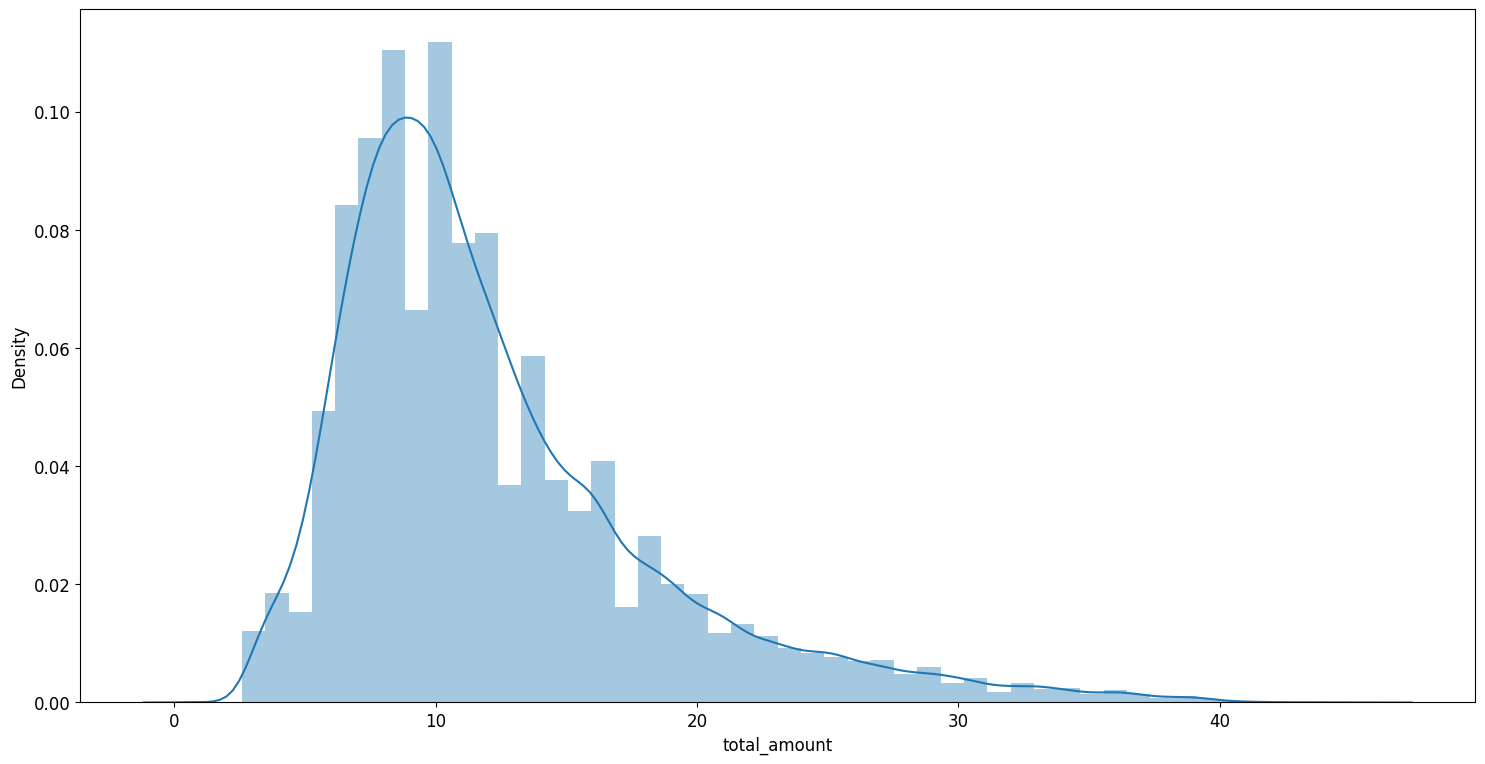

In [32]:
sns.distplot(df.loc[:, "total_amount"]);

### 3.1.2. Numerical variables

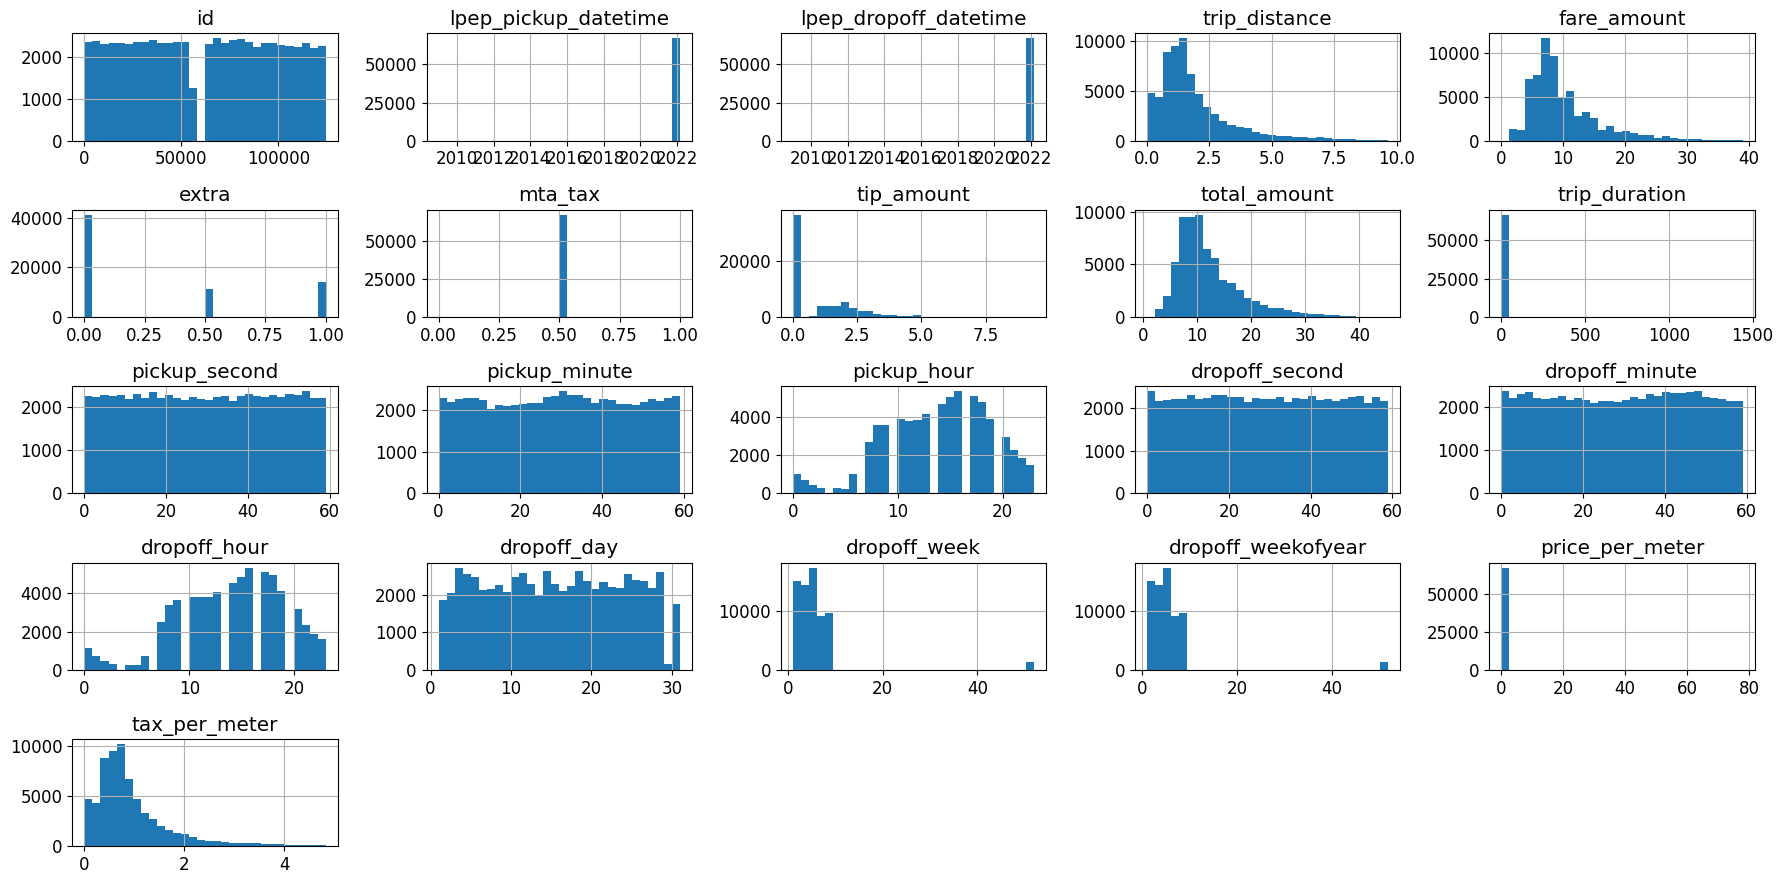

In [33]:
df.hist(bins=30);
plt.tight_layout()

## 3.2. Bivariate analysis

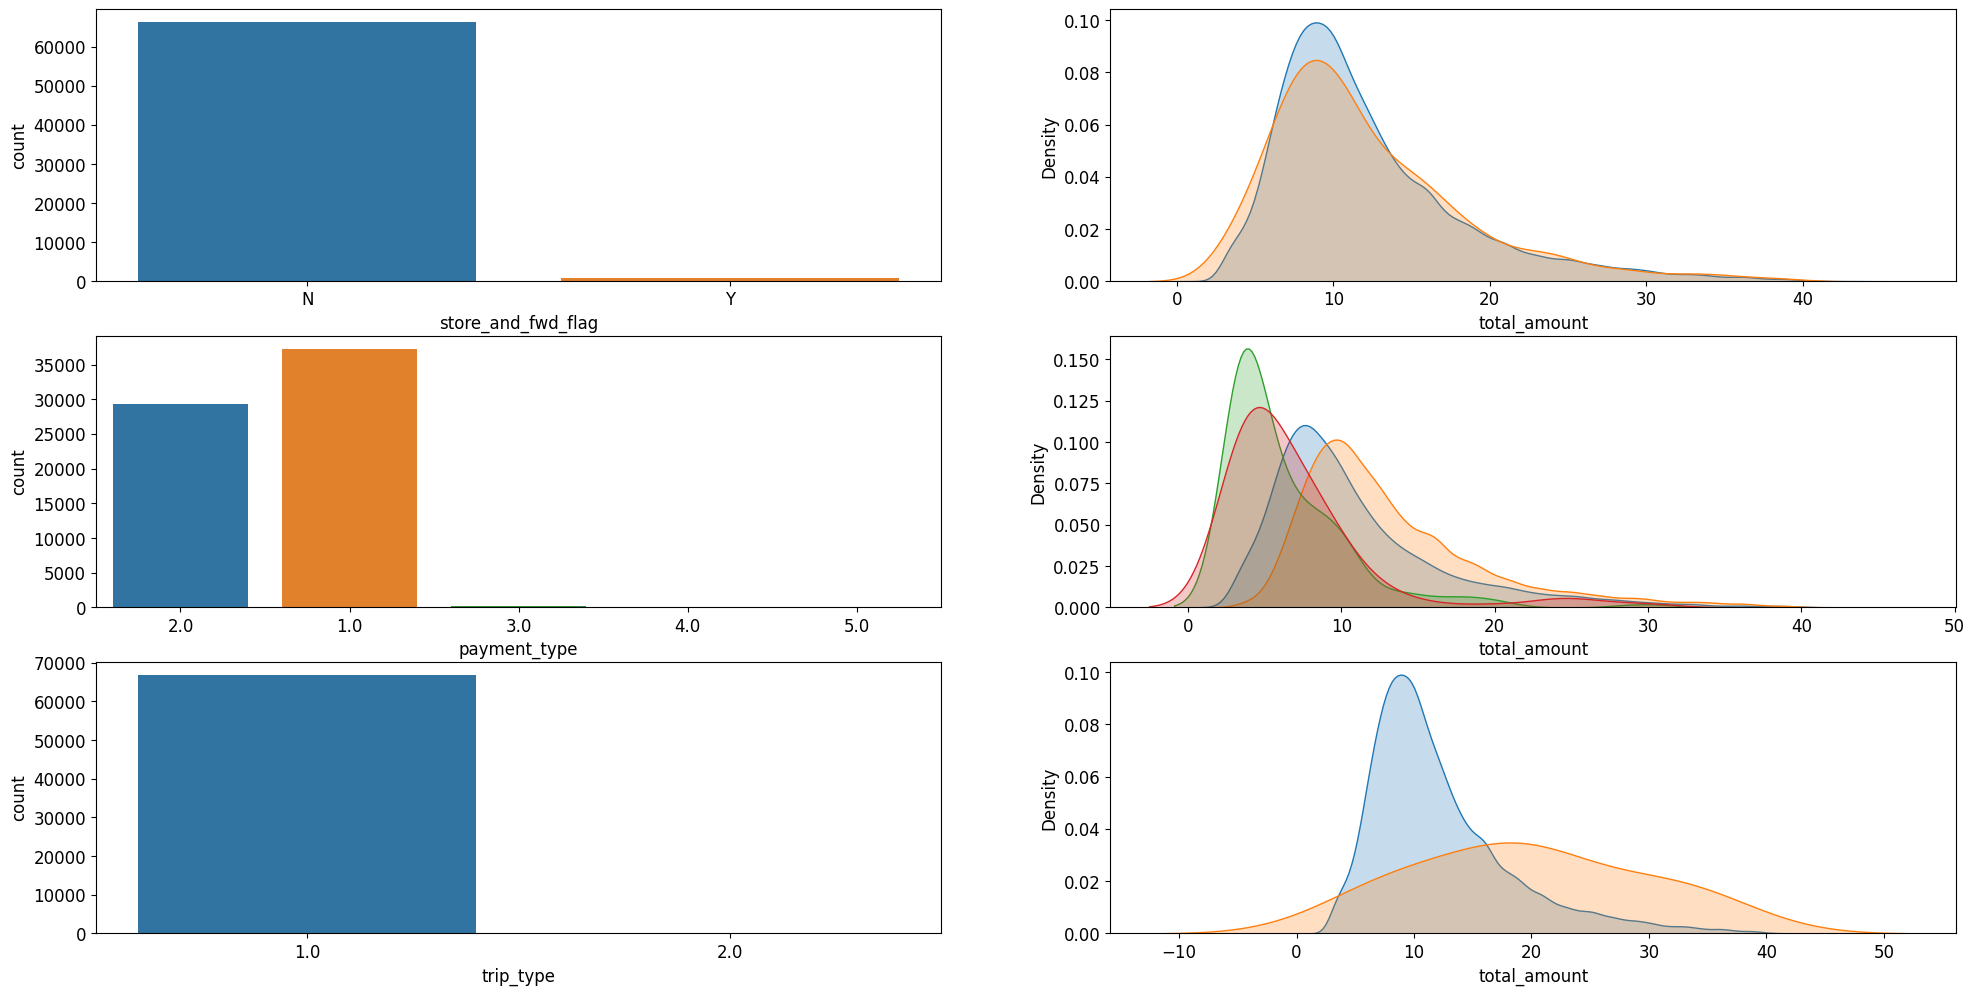

In [34]:
_, ax = plt.subplots(nrows=3, ncols=2, figsize=(24,12))
for idx, column in enumerate(["store_and_fwd_flag", "payment_type", "trip_type"]):
    sns.countplot(x=column, data=df, ax=ax[idx][0]);
    for category in df.loc[:, column].unique():
        sns.kdeplot(
            x="total_amount",
            data=df.loc[df.loc[:, column] == category, :],
            label=category,
            shade=True,
            ax=ax[idx][1]
        );

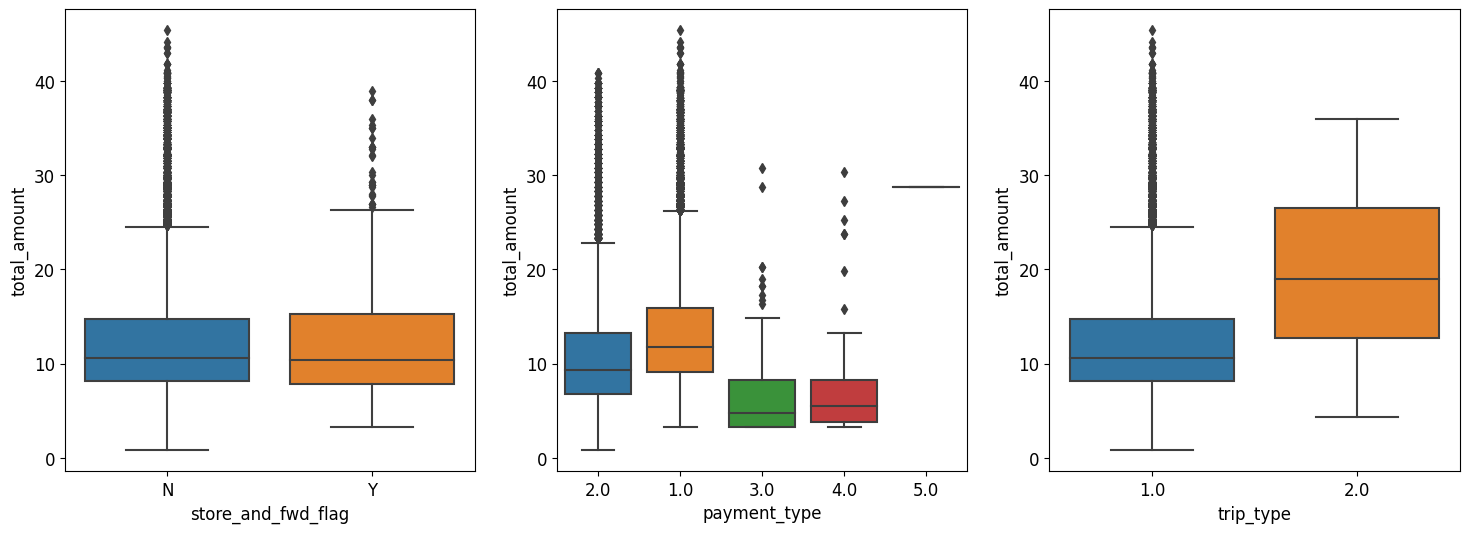

In [38]:
_, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,6))
sns.boxplot(x="store_and_fwd_flag", y="total_amount", data=df, ax=ax[0]);
sns.boxplot(x="payment_type", y="total_amount", data=df, ax=ax[1]);
sns.boxplot(x="trip_type", y="total_amount", data=df, ax=ax[2]);

[03/08/23 10:03:18] INFO     Using categorical units to plot a list of strings that are all         ]8;id=429816;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=943821;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/matplotlib/category.py#223\223]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

                    INFO     Using categorical units to plot a list of strings that are all         ]8;id=326574;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=680456;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/matplotlib/category.py#223\223]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

[03/08/23 10:03:19] INFO     Using categorical units to plot a list of strings that are all         ]8;id=263121;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=160864;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/matplotlib/category.py#223\223]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

                    INFO     Using categorical units to plot a list of strings that are all         ]8;id=777597;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=82914;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/matplotlib/category.py#223\223]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

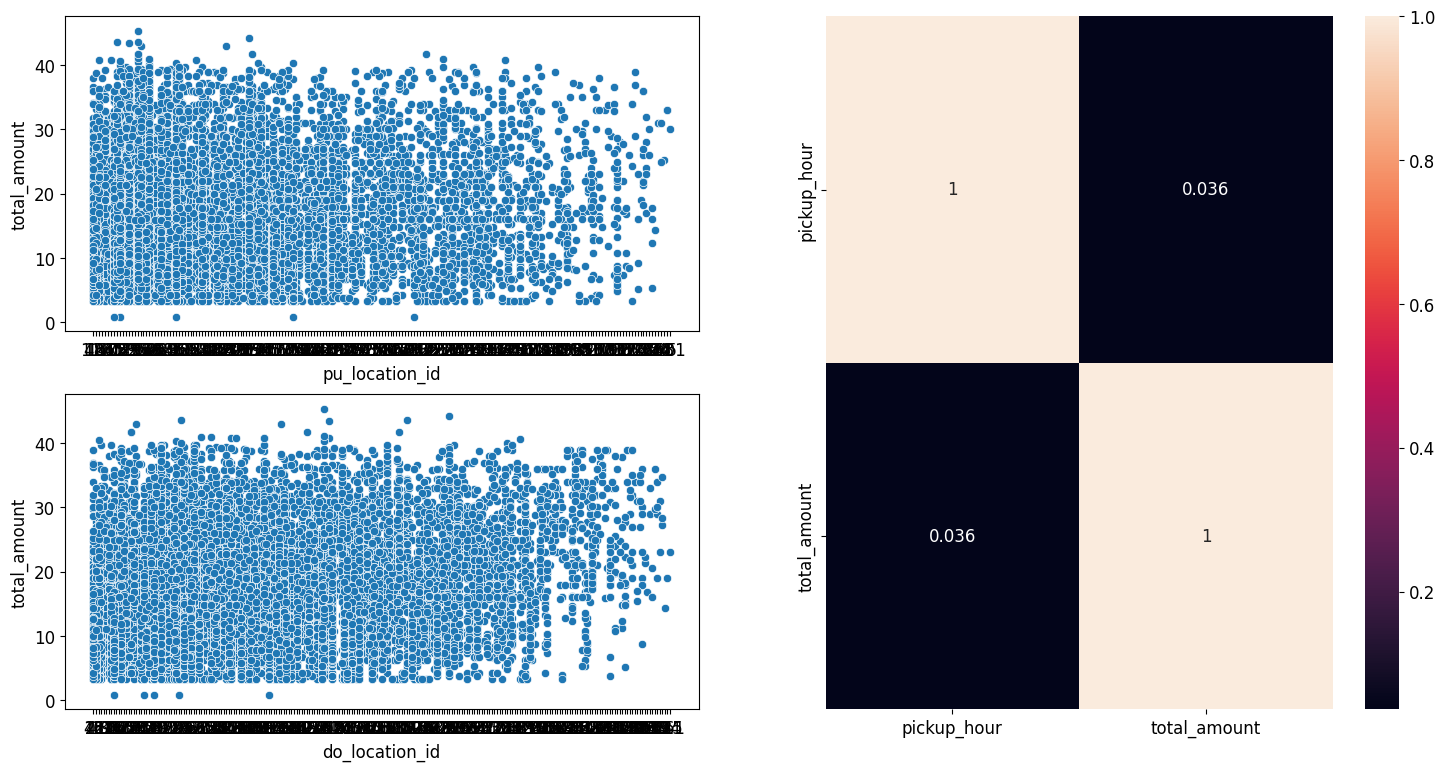

In [62]:
plt.subplot(2, 2, 1)
sns.scatterplot(x="pu_location_id", y="total_amount", data=df);
plt.subplot(2, 2, 3)
sns.scatterplot(x="do_location_id", y="total_amount", data=df);
plt.subplot(2, 2, (2, 4))
sns.heatmap(df.loc[:, ["pickup_hour", "total_amount"]].corr(), annot=True);

## 3.3. Multivariate analysis

### 3.3.1. Numerical variables

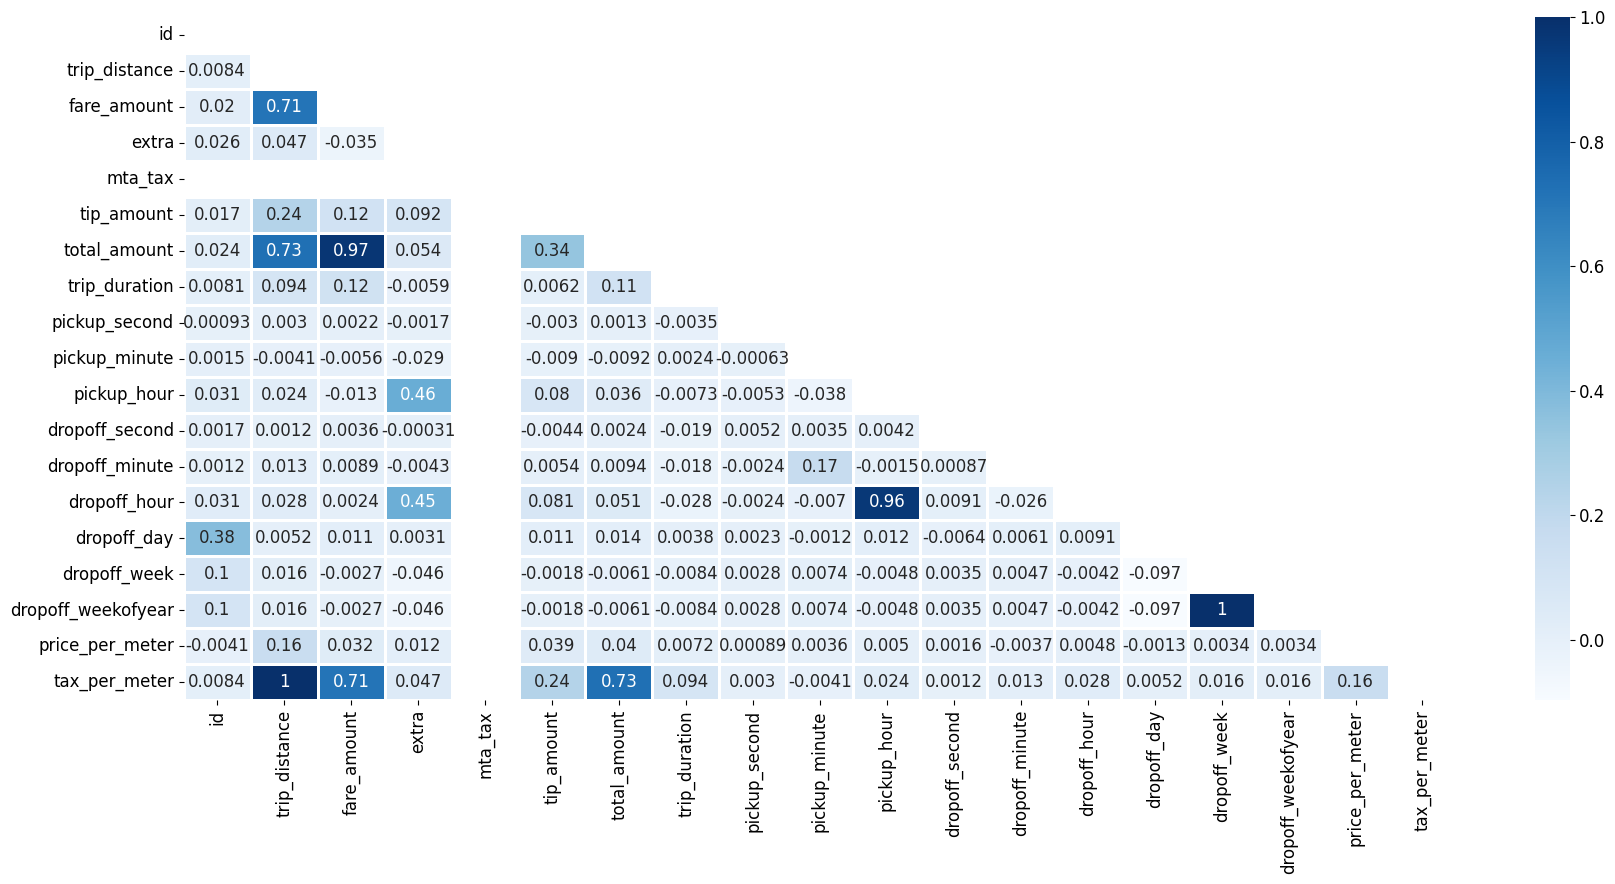

In [63]:
# Compute the correlation matrix
numerical_correlations = df.select_dtypes(include=["int", "float"]).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(numerical_correlations, dtype=bool))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    numerical_correlations,
    mask=mask,
    cmap="Blues",
    annot=True,
    linewidths=2
);
plt.tight_layout()

# 4. Data preprocessing

## 4.1. Data split

In [218]:
X = df.drop("total_amount", axis=1)
y = df.loc[:, "total_amount"]
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    shuffle=True,
)

# Assert splited data dimensions
assert X_train.shape[0] == y_train.shape[0]
assert X_val.shape[0] == y_val.shape[0]

## 4.2. Standardization

In [219]:
columns_to_standardize: List[str] = [
    "trip_distance", "fare_amount", "tip_amount",
    "price_per_meter", "trip_duration", "tax_per_meter",
]
for column in columns_to_standardize:
    standard_scaler = pp.StandardScaler()
    X_train.loc[:, [column]] = standard_scaler.fit_transform(X_train.loc[:, [column]])
    X_val.loc[:, [column]] = standard_scaler.transform(X_val.loc[:, [column]])
    joblib.dump(
        standard_scaler,
        os.path.join(
            PREPROCESSORS_DIR,
            "standard_scaler",
            f"{column}.joblib"
        )
    )

## 4.3. Rescale

### 4.3.1. RobustScaler

In [220]:
columns_to_rescale: List[str] =  ["extra", "mta_tax", "tip_amount"]
for column in columns_to_rescale:
    robust_scaler = pp.RobustScaler()
    X_train.loc[:, [column]] = robust_scaler.fit_transform(X_train.loc[:, [column]])
    X_val.loc[:, [column]] = robust_scaler.transform(X_val.loc[:, [column]])
    joblib.dump(
        robust_scaler,
        os.path.join(
            PREPROCESSORS_DIR,
            "robust_scaler",
            f"{column}.joblib"
        )
    )

## 4.4. Encoding

### 4.4.1. One-hot encoding

In [221]:
columns_to_one_hot_encode: List[str] = [
    "vendor_id",
    "store_and_fwd_flag",
    "ratecode_id",
    "payment_type",
    "trip_type",
]
X_train = pd.get_dummies(X_train, columns=columns_to_one_hot_encode, drop_first=True)
X_val = pd.get_dummies(X_val, columns=columns_to_one_hot_encode, drop_first=True)

### 4.4.2. Frequency encoding

In [222]:
columns_to_frequency_encode: List[str] = [
    "pu_location_id",
    "do_location_id",
    "location_id"
]
for column in columns_to_frequency_encode:
    column_frequency: pd.Series = X_train.groupby(column).size() / len(X_train)
    X_train.loc[:, column] = X_train.loc[:, column].map(column_frequency)
    X_val.loc[:, column] = X_val.loc[:, column].map(column_frequency)

## 4.5. Transformation

### 4.5.1. Nature transformation
References:
- [NVidia developer blog](https://developer.nvidia.com/blog/three-approaches-to-encoding-time-information-as-features-for-ml-models/)
- [Kaggle notebook](https://www.kaggle.com/code/avanwyk/encoding-cyclical-features-for-deep-learning)

In [223]:
# Create a respective sin and cosine for cyclical feature
X_train: pd.DataFrame = X_train.assign(
    pickup_second_sin=(
        X_train.loc[:, "pickup_second"].apply(lambda x: np.sin(x * (2.0 * np.pi / 60)))
    ),
    pickup_second_cos=(
        X_train.loc[:, "pickup_second"].apply(lambda x: np.cos(x * (2.0 * np.pi / 60)))
    ),
    pickup_minute_sin=(
        X_train.loc[:, "pickup_minute"].apply(lambda x: np.sin(x * (2.0 * np.pi / 60)))
    ),
    pickup_minute_cos=(
        X_train.loc[:, "pickup_minute"].apply(lambda x: np.cos(x * (2.0 * np.pi / 60)))
    ),
    pickup_hour_sin=(
        X_train.loc[:, "pickup_hour"].apply(lambda x: np.sin(x * (2.0 * np.pi / 24)))
    ),
    pickup_hour_cos=(
        X_train.loc[:, "pickup_hour"].apply(lambda x: np.cos(x * (2.0 * np.pi / 24)))
    ),
    dropoff_second_sin=(
        X_train.loc[:, "dropoff_second"].apply(lambda x: np.sin(x * (2.0 * np.pi / 60)))
    ),
    dropoff_second_cos=(
        X_train.loc[:, "dropoff_second"].apply(lambda x: np.cos(x * (2.0 * np.pi / 60)))
    ),
    dropoff_minute_sin=(
        X_train.loc[:, "dropoff_minute"].apply(lambda x: np.sin(x * (2.0 * np.pi / 60)))
    ),
    dropoff_minute_cos=(
        X_train.loc[:, "dropoff_minute"].apply(lambda x: np.cos(x * (2.0 * np.pi / 60)))
    ),
    dropoff_hour_sin=(
        X_train.loc[:, "dropoff_hour"].apply(lambda x: np.sin(x * (2.0 * np.pi / 24)))
    ),
    dropoff_hour_cos=(
        X_train.loc[:, "dropoff_hour"].apply(lambda x: np.cos(x * (2.0 * np.pi / 24)))
    ),
    dropoff_day_sin=(
        X_train.loc[:, "dropoff_day"].apply(lambda x: np.sin(x * (2.0 * np.pi / 30)))
    ),
    dropoff_day_cos=(
        X_train.loc[:, "dropoff_day"].apply(lambda x: np.cos(x * (2.0 * np.pi / 30)))
    ),
    dropoff_week_sin=(
        X_train.loc[:, "dropoff_week"].apply(lambda x: np.sin(x * (2.0 * np.pi / 7)))
    ),
    dropoff_week_cos=(
        X_train.loc[:, "dropoff_week"].apply(lambda x: np.cos(x * (2.0 * np.pi / 7)))
    ),
    dropoff_weekofyear_sin=(
        X_train.loc[:, "dropoff_weekofyear"].apply(lambda x: np.sin(x * (2.0 * np.pi / 52)))
    ),
    dropoff_weekofyear_cos=(
        X_train.loc[:, "dropoff_weekofyear"].apply(lambda x: np.cos(x * (2.0 * np.pi / 52)))
    )
)
X_val: pd.DataFrame = X_val.assign(
    pickup_second_sin=(
        X_val.loc[:, "pickup_second"].apply(lambda x: np.sin(x * (2.0 * np.pi / 60)))
    ),
    pickup_second_cos=(
        X_val.loc[:, "pickup_second"].apply(lambda x: np.cos(x * (2.0 * np.pi / 60)))
    ),
    pickup_minute_sin=(
        X_val.loc[:, "pickup_minute"].apply(lambda x: np.sin(x * (2.0 * np.pi / 60)))
    ),
    pickup_minute_cos=(
        X_val.loc[:, "pickup_minute"].apply(lambda x: np.cos(x * (2.0 * np.pi / 60)))
    ),
    pickup_hour_sin=(
        X_val.loc[:, "pickup_hour"].apply(lambda x: np.sin(x * (2.0 * np.pi / 24)))
    ),
    pickup_hour_cos=(
        X_val.loc[:, "pickup_hour"].apply(lambda x: np.cos(x * (2.0 * np.pi / 24)))
    ),
    dropoff_second_sin=(
        X_val.loc[:, "dropoff_second"].apply(lambda x: np.sin(x * (2.0 * np.pi / 60)))
    ),
    dropoff_second_cos=(
        X_val.loc[:, "dropoff_second"].apply(lambda x: np.cos(x * (2.0 * np.pi / 60)))
    ),
    dropoff_minute_sin=(
        X_val.loc[:, "dropoff_minute"].apply(lambda x: np.sin(x * (2.0 * np.pi / 60)))
    ),
    dropoff_minute_cos=(
        X_val.loc[:, "dropoff_minute"].apply(lambda x: np.cos(x * (2.0 * np.pi / 60)))
    ),
    dropoff_hour_sin=(
        X_val.loc[:, "dropoff_hour"].apply(lambda x: np.sin(x * (2.0 * np.pi / 24)))
    ),
    dropoff_hour_cos=(
        X_val.loc[:, "dropoff_hour"].apply(lambda x: np.cos(x * (2.0 * np.pi / 24)))
    ),
    dropoff_day_sin=(
        X_val.loc[:, "dropoff_day"].apply(lambda x: np.sin(x * (2.0 * np.pi / 30)))
    ),
    dropoff_day_cos=(
        X_val.loc[:, "dropoff_day"].apply(lambda x: np.cos(x * (2.0 * np.pi / 30)))
    ),
    dropoff_week_sin=(
        X_val.loc[:, "dropoff_week"].apply(lambda x: np.sin(x * (2.0 * np.pi / 7)))
    ),
    dropoff_week_cos=(
        X_val.loc[:, "dropoff_week"].apply(lambda x: np.cos(x * (2.0 * np.pi / 7)))
    ),
    dropoff_weekofyear_sin=(
        X_val.loc[:, "dropoff_weekofyear"].apply(lambda x: np.sin(x * (2.0 * np.pi / 52)))
    ),
    dropoff_weekofyear_cos=(
        X_val.loc[:, "dropoff_weekofyear"].apply(lambda x: np.cos(x * (2.0 * np.pi / 52)))
    )
)

In [224]:
# Check it out
X_train.sample(3)

,id,lpep_pickup_datetime,lpep_dropoff_datetime,pu_location_id,do_location_id,trip_distance,fare_amount,extra,mta_tax,tip_amount,trip_duration,pickup_second,pickup_minute,pickup_hour,dropoff_second,dropoff_minute,dropoff_hour,dropoff_day,dropoff_week,dropoff_weekofyear,location_id,price_per_meter,tax_per_meter,vendor_id_2,store_and_fwd_flag_Y,ratecode_id_4.0,ratecode_id_5.0,ratecode_id_6.0,payment_type_2.0,payment_type_3.0,payment_type_4.0,trip_type_2.0,pickup_second_sin,pickup_second_cos,pickup_minute_sin,pickup_minute_cos,pickup_hour_sin,pickup_hour_cos,dropoff_second_sin,dropoff_second_cos,dropoff_minute_sin,dropoff_minute_cos,dropoff_hour_sin,dropoff_hour_cos,dropoff_day_sin,dropoff_day_cos,dropoff_week_sin,dropoff_week_cos,dropoff_weekofyear_sin,dropoff_weekofyear_cos
34538,34539,2022-01-20 00:14:18,2022-01-20 00:22:37,0.027837,0.001643,-0.145659,-0.360168,1.0,0.0,0.000000,-0.101182,18,14,0,37,22,0,20,3,3,0.000504,0.121693,-0.145659,1,0,0,0,0,0,0,0,0,0.951057,-0.309017,0.994522,1.045285e-01,0.000000,1.000000,-0.669131,-0.743145,0.743145,-0.669131,0.000000,1.000000,-0.866025,-0.500000,0.433884,-0.900969,0.354605,0.935016
18714,18715,2022-01-11 14:26:29,2022-01-11 14:44:17,0.172865,0.009596,1.823895,1.198880,0.0,0.0,1.816327,0.016543,29,26,14,17,44,14,11,2,2,0.002427,0.444909,1.823895,1,0,0,0,0,0,0,0,0,0.104528,-0.994522,0.406737,-9.135455e-01,-0.500000,-0.866025,0.978148,-0.207912,-0.994522,-0.104528,-0.500000,-0.866025,0.743145,-0.669131,0.974928,-0.222521,0.239316,0.970942
68267,68268,2022-02-03 15:15:07,2022-02-03 15:25:16,0.033008,0.014507,-0.483478,-0.360168,0.0,0.0,0.897959,-0.078423,7,15,15,16,25,15,3,5,5,0.004331,-0.171267,-0.483478,1,0,0,0,0,0,0,0,0,0.669131,0.743145,1.000000,6.123234e-17,-0.707107,-0.707107,0.994522,-0.104528,0.500000,-0.866025,-0.707107,-0.707107,0.587785,0.809017,-0.974928,-0.222521,0.568065,0.822984


# 5. Feature selection

In [225]:
columns_derivated_to_drop: List[str] = [
    "lpep_pickup_datetime", "lpep_dropoff_datetime",
    "pickup_second", "pickup_minute", "pickup_hour",
    "dropoff_second", "dropoff_minute", "dropoff_hour",
    "dropoff_day", "dropoff_week", "dropoff_weekofyear"
]
X_train.drop(columns_derivated_to_drop, axis=1, inplace=True)
X_val.drop(columns_derivated_to_drop, axis=1, inplace=True)

In [35]:
# Regressor that will be used in both feature selection techniques
xtrees_classifier = ExtraTreesRegressor()
xtrees_classifier.fit(
    X_train.drop("id", axis=1).to_numpy(),
    y_train.to_numpy(),
)

ExtraTreesRegressor()

## 5.1. Feature importance

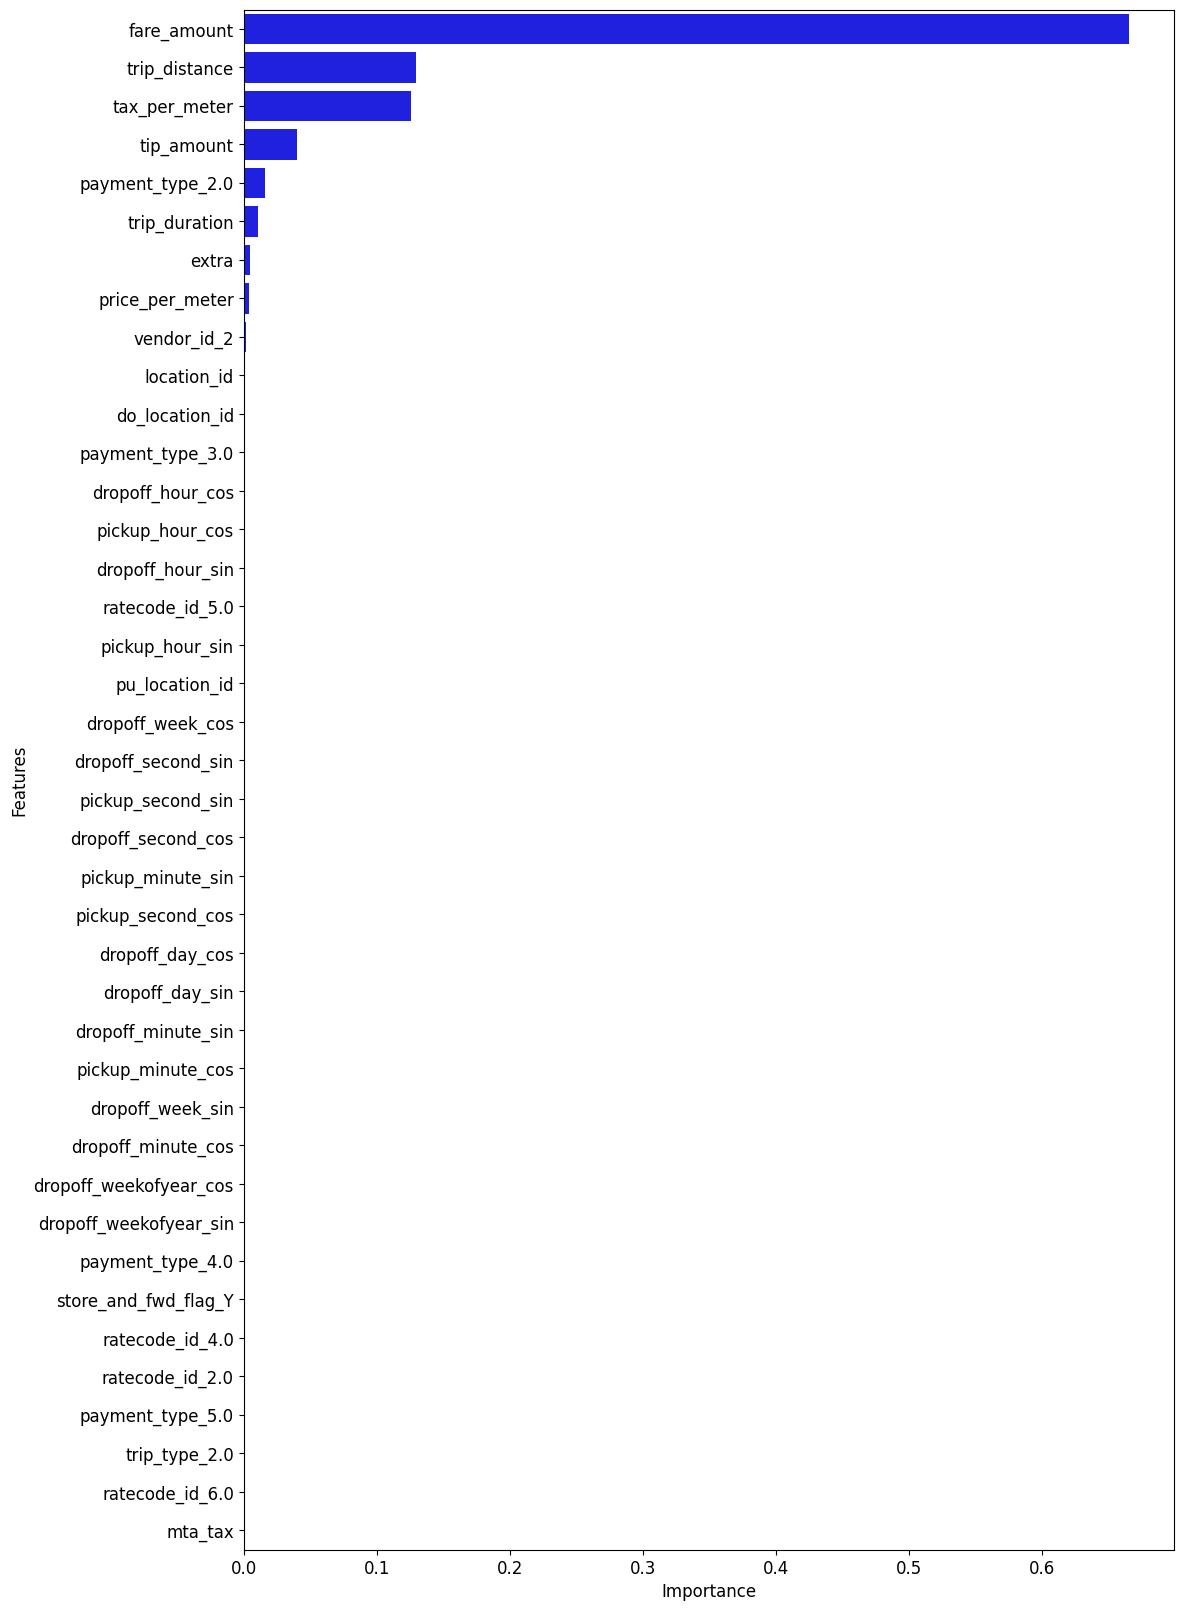

In [37]:
# Store feature importance into a dataframe and plot it
df_feature_importance = pd.DataFrame({
    "Features": X_train.drop("id", axis=1).columns,
    "Importance": xtrees_classifier.feature_importances_
}).sort_values(by="Importance", ascending=False) \
  .reset_index(drop=True)
plt.figure(figsize=(12,20))
sns.barplot(
    x="Importance",
    y="Features",
    data=df_feature_importance,
    orient="h",
    color='blue'
);

## 5.2. Wrapper

In [40]:
# Wrapper methods are usually highly computationally expensive.
# For this reason, I'm using using very low numbers for estimators and iterations
borutapy = BorutaPy(
    estimator=xtrees_classifier,
    n_estimators=10,
    max_iter=10,
    verbose=1
).fit(X_train.drop("id", axis=1).to_numpy(), y_train.to_numpy())

Iteration: 1 / 10
Iteration: 2 / 10
Iteration: 3 / 10
Iteration: 4 / 10
Iteration: 5 / 10
Iteration: 6 / 10
Iteration: 7 / 10
Iteration: 8 / 10
Iteration: 9 / 10


BorutaPy finished running.

Iteration: 	10 / 10
Confirmed: 	30
Tentative: 	2
Rejected: 	6


In [41]:
boruta_best_features: List[bool] = borutapy.support_.tolist()
selected_columns_by_boruta: List[str] = [
    column for column, is_selected, rank
    in zip(X_train.columns, boruta_best_features, borutapy.ranking_)
    if is_selected and rank == 1
]
print(selected_columns_by_boruta)

['id', 'pu_location_id', 'do_location_id', 'trip_distance', 'fare_amount', 'mta_tax', 'tip_amount', 'trip_duration', 'location_id', 'price_per_meter', 'tax_per_meter', 'ratecode_id_6.0', 'trip_type_2.0', 'pickup_second_sin', 'pickup_second_cos', 'pickup_minute_sin', 'pickup_minute_cos', 'pickup_hour_sin', 'pickup_hour_cos', 'dropoff_second_sin', 'dropoff_second_cos', 'dropoff_minute_sin', 'dropoff_minute_cos', 'dropoff_hour_sin', 'dropoff_hour_cos', 'dropoff_day_sin', 'dropoff_day_cos', 'dropoff_week_sin', 'dropoff_week_cos', 'dropoff_weekofyear_sin']


## 5.3. Select columns

In [226]:
selected_columns: List[str] = [
    "id", "fare_amount", "trip_distance", "tax_per_meter",
    "trip_duration", "extra", "tip_amount", "payment_type_2.0"
]
X_train = X_train.loc[:, selected_columns]
X_val = X_val.loc[:, selected_columns]
X_train.sample(3)

,id,fare_amount,trip_distance,tax_per_meter,trip_duration,extra,tip_amount,payment_type_2.0
5302,5303,-1.226306,-1.089004,-1.089004,-0.184768,0.0,0.000000,1
84586,84587,4.698076,-1.210110,-1.210110,0.237096,0.0,0.000000,0
35968,35969,0.765811,1.396839,1.396839,-0.034561,2.0,2.494898,0


# 6. Machine learning modeling

In [227]:
def get_metrics(
    scores: Dict[str, np.ndarray],
    n_decimals: Optional[int] = 6,
    show_std: Optional[bool] = True
) -> Dict[str, str]:
    """Convert scores given by scikit-learn model selection function
        `cross_validate` to human-readable metrics.
    Args:
        scores (dict[str, np.ndarray]): Dictionary containing the metrics
            scores for each iteration over the model.
        n_decimals (int): Desired number of decimals for all metrics.
        show_td (bool): Whether standard deviation values should be shown.
    Returns:
        Dictionary containing the metrics `MAE`, `RMSE` and `MAPE`,
            and their respective standard deviation.
    """
    mae: float = np.round(np.mean(scores["test_neg_mean_absolute_error"]), n_decimals) * (-1)
    mae_std: float = np.round(np.std(scores["test_neg_mean_absolute_error"]), n_decimals)
    rmse: float = np.round(np.mean(scores["test_neg_root_mean_squared_error"]), n_decimals) * (-1)
    rmse_std: float = np.round(np.std(scores["test_neg_root_mean_squared_error"]), n_decimals)
    mape: float = (np.round(np.mean(scores["test_neg_mean_absolute_percentage_error"]), n_decimals) * (-1)) * 100
    mape_std: float = (np.round(np.std(scores["test_neg_mean_absolute_percentage_error"]), n_decimals)) * 100
    if show_std: 
        return {
            "MAE": mae, "MAE std (+/-)": mae_std,
            "RMSE": rmse, "RMSE std (+/-)": rmse_std,
            "MAPE": mape, "MAPE std (+/-)": mape_std,
        }
    return {
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape,
    }

## 6.1. Baseline

In [235]:
scores_dummy: List[float] = cross_validate(
    DummyRegressor(),
    X_train.drop("id", axis=1).to_numpy(),
    y_train.to_numpy(),
    scoring=(
        "neg_mean_absolute_error",
        "neg_root_mean_squared_error",
        "neg_mean_absolute_percentage_error"
    ),
    cv=10,
    n_jobs=(-1)
)
%time dummy_results: Dict[str, float] = get_metrics(scores_dummy)
print(dummy_results)            

CPU times: user 178 µs, sys: 142 µs, total: 320 µs
Wall time: 325 µs
{'MAE': 4.557221, 'MAE std (+/-)': 0.031398, 'RMSE': 6.089248, 'RMSE std (+/-)': 0.080912, 'MAPE': 44.663000000000004, 'MAPE std (+/-)': 0.5564}


## 6.2. Linear regression

In [234]:
scores_lr: List[float] = cross_validate(
    LinearRegression(),
    X_train.drop("id", axis=1).to_numpy(),
    y_train.to_numpy(),
    scoring=(
        "neg_mean_absolute_error",
        "neg_root_mean_squared_error",
        "neg_mean_absolute_percentage_error"
    ),
    cv=10,
    n_jobs=(-1)
)
%time lr_results: Dict[str, float] = get_metrics(scores_lr)
print(lr_results)

CPU times: user 199 µs, sys: 160 µs, total: 359 µs
Wall time: 364 µs
{'MAE': 0.001131, 'MAE std (+/-)': 0.000335, 'RMSE': 0.028701, 'RMSE std (+/-)': 0.015516, 'MAPE': 0.0085, 'MAPE std (+/-)': 0.0029}


## 6.3. KNeighborsRegressor

In [176]:
scores_knn: List[float] = cross_validate(
    KNeighborsRegressor(),
    X_train.drop("id", axis=1).to_numpy(),
    y_train.to_numpy(),
    scoring=(
        "neg_mean_absolute_error",
        "neg_root_mean_squared_error",
        "neg_mean_absolute_percentage_error"
    ),
    cv=10,
    n_jobs=(-1)
)
%time knn_results: Dict[str, float] = get_metrics(scores_knn)
print(knn_results)

CPU times: user 323 µs, sys: 166 µs, total: 489 µs
Wall time: 501 µs
{'MAE': 0.078688, 'MAE std (+/-)': 0.003744, 'RMSE': 0.28727, 'RMSE std (+/-)': 0.02587, 'MAPE': 0.5097, 'MAPE std (+/-)': 0.035500000000000004}


## 6.4. HistGradientBoostingRegressor

In [177]:
scores_hgb: List[float] = cross_validate(
    HistGradientBoostingRegressor(),
    X_train.drop("id", axis=1).to_numpy(),
    y_train.to_numpy(),
    scoring=(
        "neg_mean_absolute_error",
        "neg_root_mean_squared_error",
        "neg_mean_absolute_percentage_error"
    ),
    cv=10,
    n_jobs=(-1)
)
%time hgb_results: Dict[str, float] = get_metrics(scores_hgb)
print(hgb_results)

CPU times: user 312 µs, sys: 160 µs, total: 472 µs
Wall time: 486 µs
{'MAE': 0.043325, 'MAE std (+/-)': 0.002231, 'RMSE': 0.094883, 'RMSE std (+/-)': 0.010836, 'MAPE': 0.3587, 'MAPE std (+/-)': 0.029300000000000003}


## 6.5. LightGBMRegressor

In [178]:
scores_lgbm: List[float] = cross_validate(
    LGBMRegressor(),
    X_train.drop("id", axis=1).to_numpy(),
    y_train.to_numpy(),
    scoring=(
        "neg_mean_absolute_error",
        "neg_root_mean_squared_error",
        "neg_mean_absolute_percentage_error"
    ),
    cv=10,
    n_jobs=(-1)
)
%time lgbm_results: Dict[str, float] = get_metrics(scores_lgbm)
print(lgbm_results)

CPU times: user 674 µs, sys: 346 µs, total: 1.02 ms
Wall time: 1.05 ms
{'MAE': 0.040505, 'MAE std (+/-)': 0.001203, 'RMSE': 0.084275, 'RMSE std (+/-)': 0.011239, 'MAPE': 0.3388, 'MAPE std (+/-)': 0.0202}


## 6.6. XGBoostRegressor

In [179]:
scores_xgb: List[float] = cross_validate(
    XGBRegressor(),
    X_train.drop("id", axis=1).to_numpy(),
    y_train.to_numpy(),
    scoring=(
        "neg_mean_absolute_error",
        "neg_root_mean_squared_error",
        "neg_mean_absolute_percentage_error"
    ),
    cv=10,
    n_jobs=(-1)
)
%time xgb_results: Dict[str, float] = get_metrics(scores_xgb)
print(xgb_results)

CPU times: user 284 µs, sys: 145 µs, total: 429 µs
Wall time: 445 µs
{'MAE': 0.02447, 'MAE std (+/-)': 0.001734, 'RMSE': 0.063032, 'RMSE std (+/-)': 0.011778, 'MAPE': 0.2003, 'MAPE std (+/-)': 0.012899999999999998}


## 6.7. StackingRegressor

In [180]:
estimators: List[tuple[str, object]] = [
    ("lasso", Lasso()),
    ("ridge", Ridge())
]
stacking_regressor = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression()
)
scores_stacking: List[float] = cross_validate(
    stacking_regressor,
    X_train.drop("id", axis=1).to_numpy(),
    y_train.to_numpy(),
    scoring=(
        "neg_mean_absolute_error",
        "neg_root_mean_squared_error",
        "neg_mean_absolute_percentage_error"
    ),
    cv=10,
    n_jobs=(-1)
)
%time stacking_results: Dict[str, float] = get_metrics(scores_stacking)
print(stacking_results)

CPU times: user 190 µs, sys: 98 µs, total: 288 µs
Wall time: 294 µs
{'MAE': 0.001189, 'MAE std (+/-)': 0.000523, 'RMSE': 0.022204, 'RMSE std (+/-)': 0.02238, 'MAPE': 0.009000000000000001, 'MAPE std (+/-)': 0.0034}


## 6.8. Ridge

In [181]:
scores_ridge: List[float] = cross_validate(
    Ridge(),
    X_train.drop("id", axis=1).to_numpy(),
    y_train.to_numpy(),
    scoring=(
        "neg_mean_absolute_error",
        "neg_root_mean_squared_error",
        "neg_mean_absolute_percentage_error"
    ),
    cv=10,
    n_jobs=(-1)
)
%time ridge_results: Dict[str, float] = get_metrics(scores_ridge)
print(ridge_results)

CPU times: user 285 µs, sys: 147 µs, total: 432 µs
Wall time: 445 µs
{'MAE': 0.001149, 'MAE std (+/-)': 0.000528, 'RMSE': 0.022173, 'RMSE std (+/-)': 0.022412, 'MAPE': 0.0087, 'MAPE std (+/-)': 0.0034}


## 6.9. Compare models

In [182]:
df_model_comparison = pd.DataFrame(
    data=[
        dummy_results, lr_results,
        knn_results, hgb_results,
        lgbm_results, xgb_results,
        stacking_results, ridge_results
    ],
    columns=["MAE", "MAE std (+/-)", "RMSE", "RMSE std (+/-)", "MAPE", "MAPE std (+/-)"],
    index=[
        "DummyRegressor",
        "LinearRegression",
        "KNeighborsRegressor",
        "HistGradientBoostingRegressor",
        "LightGBMRegressor",
        "XGBoostRegressor",
        "StackingRegressor",
        "Ridge"
    ]
).sort_values(by="RMSE", ascending=True)
df_model_comparison

,MAE,MAE std (+/-),RMSE,RMSE std (+/-),MAPE,MAPE std (+/-)
Ridge,0.001149,0.000528,0.022173,0.022412,0.0087,0.0034
LinearRegression,0.001107,0.000537,0.022179,0.022404,0.0082,0.0035
StackingRegressor,0.001189,0.000523,0.022204,0.022380,0.0090,0.0034
XGBoostRegressor,0.024470,0.001734,0.063032,0.011778,0.2003,0.0129
LightGBMRegressor,0.040505,0.001203,0.084275,0.011239,0.3388,0.0202
HistGradientBoostingRegressor,0.043325,0.002231,0.094883,0.010836,0.3587,0.0293
KNeighborsRegressor,0.078688,0.003744,0.287270,0.025870,0.5097,0.0355
DummyRegressor,4.569876,0.051848,6.098976,0.090743,44.8540,0.6110


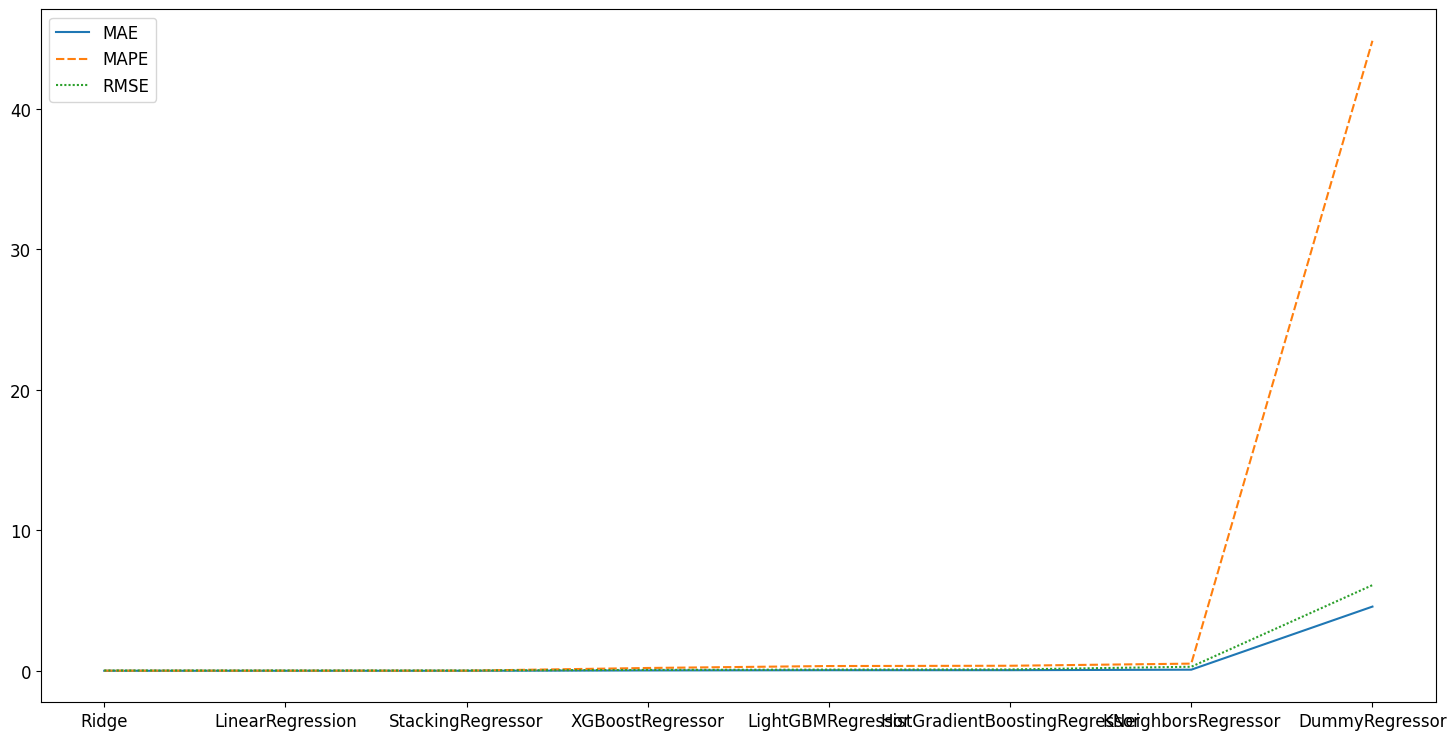

In [185]:
sns.lineplot(data=df_model_comparison.loc[:, ["MAE", "MAPE", "RMSE"]]);

# 7. Hyperparameters fine-tuning

mlflow server \
    --backend-store-uri sqlite:///backend.db \
    --default-artifact-root ./mlartifacts

In [75]:
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)

2023/03/08 10:05:17 INFO mlflow.tracking.fluent: Experiment with name 'Experiment_02' does not exist. Creating a new experiment.


<Experiment: artifact_location='/home/sheep/documents/repos/predict-taxi-tip-amount/mlflow/mlartifacts/2', creation_time=1678280717927, experiment_id='2', last_update_time=1678280717927, lifecycle_stage='active', name='Experiment_02', tags={}>

## 7.1. Bayesian search

In [195]:
def objective(
    hyperparameters: Dict[str, Any],
    cv: Optional[int] = 10
) -> Dict[str, Any]:
    """Defines what should be achieved.
    Args:
        hyperparameters (dict[str, any]): Desired hyperparameters to try out.
        cv (int): Determines the cross-validation splitting strategy.
    Returns:
        Dictionary containing the loss value, its respective hyperparameters
            that were used, and an OK status.
    """
    mlflow.set_tags({
        "developer": "Gabriel Cenciati",
        "release_candidate": "Linear Regression",
        "used_training_data": glob(os.path.join(DATA_DIR, "raw", "train", "*.dvc"))
    })
    with mlflow.start_run(
        run_name=f"Bayesian_Search_Fine_Tuning",
        nested=True
    ):
        regressor = Ridge(**hyperparameters)
        scores: List[float] = cross_validate(
            regressor,
            X_val.drop("id", axis=1).to_numpy(),
            y_val.to_numpy(),
            cv=cv,
            scoring=(
                "neg_mean_absolute_error",
                "neg_root_mean_squared_error",
                "neg_mean_absolute_percentage_error"
            ),
        )
        results: Dict[str, float] = get_metrics(scores, show_std=False)
        mlflow.sklearn.log_model(
            regressor.fit(
                X_train.drop("id", axis=1).to_numpy(),
                y_train.to_numpy()
            ),
            ARTIFACT_DIR
        )
        mlflow.log_params(hyperparameters)
        mlflow.log_metrics(results)
        return {
            "loss": results["RMSE"],
            "hyperparameters": hyperparameters,
            "status": STATUS_OK
        }

In [197]:
search_space: Dict[str, int | float] = {
    "alpha": hp.choice("alpha", [0, 200, 230, 265, 270, 290, 300, 500]),
    "max_iter": hp.choice("max_iter", [100, 500, 1000, 1500, 5000]),
    "solver": hp.choice("solver", ["auto", "svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga"]),
}
bayes_trials = Trials()
MAX_EVALS: int = 20

# Minimize objective function over the search space
best_hyperparameters: Dict[str, int | float] = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    trials=bayes_trials,
    max_evals=MAX_EVALS,
    verbose=False
)
print(best_hyperparameters)

[03/08/23 12:56:56] INFO     build_posterior_wrapper took 0.002230 seconds                               ]8;id=268947;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=139901;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#864\864]8;;\

                    INFO     TPE using 0 trials                                                          ]8;id=676269;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=363911;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#900\900]8;;\

[03/08/23 12:57:00] INFO     build_posterior_wrapper took 0.001400 seconds                               ]8;id=892589;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=19476;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#864\864]8;;\

                    INFO     TPE using 1/1 trials with best loss 0.159916                                ]8;id=272283;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=585478;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#900\900]8;;\

[03/08/23 12:57:02] INFO     build_posterior_wrapper took 0.003255 seconds                               ]8;id=595033;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=954048;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#864\864]8;;\

                    INFO     TPE using 2/2 trials with best loss 0.159916                                ]8;id=735392;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=637111;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#900\900]8;;\

[03/08/23 12:57:04] INFO     build_posterior_wrapper took 0.001355 seconds                               ]8;id=946560;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=480944;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#864\864]8;;\

                    INFO     TPE using 3/3 trials with best loss 0.159916                                ]8;id=564059;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=186948;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#900\900]8;;\

[03/08/23 12:57:06] INFO     build_posterior_wrapper took 0.001715 seconds                               ]8;id=9329;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=145182;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#864\864]8;;\

                    INFO     TPE using 4/4 trials with best loss 0.159916                                ]8;id=827979;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=385038;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#900\900]8;;\

[03/08/23 12:57:09] INFO     build_posterior_wrapper took 0.001338 seconds                               ]8;id=650681;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=37397;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#864\864]8;;\

                    INFO     TPE using 5/5 trials with best loss 0.027570                                ]8;id=611792;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=303595;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#900\900]8;;\

[03/08/23 12:57:11] INFO     build_posterior_wrapper took 0.001671 seconds                               ]8;id=307659;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=120477;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#864\864]8;;\

                    INFO     TPE using 6/6 trials with best loss 0.027570                                ]8;id=50600;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=322835;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#900\900]8;;\

[03/08/23 12:57:13] INFO     build_posterior_wrapper took 0.001390 seconds                               ]8;id=74305;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=317373;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#864\864]8;;\

                    INFO     TPE using 7/7 trials with best loss 0.027570                                ]8;id=434867;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=113929;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#900\900]8;;\

[03/08/23 12:57:16] INFO     build_posterior_wrapper took 0.001629 seconds                               ]8;id=497029;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=353454;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#864\864]8;;\

                    INFO     TPE using 8/8 trials with best loss 0.027570                                ]8;id=130364;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=502358;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#900\900]8;;\

[03/08/23 12:57:18] INFO     build_posterior_wrapper took 0.001519 seconds                               ]8;id=39661;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=316568;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#864\864]8;;\

                    INFO     TPE using 9/9 trials with best loss 0.027570                                ]8;id=163225;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=964363;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#900\900]8;;\

[03/08/23 12:57:20] INFO     build_posterior_wrapper took 0.002471 seconds                               ]8;id=845276;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=669912;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#864\864]8;;\

                    INFO     TPE using 10/10 trials with best loss 0.024764                              ]8;id=207660;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=786295;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#900\900]8;;\

[03/08/23 12:57:22] INFO     build_posterior_wrapper took 0.001664 seconds                               ]8;id=102840;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=412937;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#864\864]8;;\

                    INFO     TPE using 11/11 trials with best loss 0.024764                              ]8;id=964850;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=512353;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#900\900]8;;\

[03/08/23 12:57:25] INFO     build_posterior_wrapper took 0.001345 seconds                               ]8;id=227806;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=443587;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#864\864]8;;\

                    INFO     TPE using 12/12 trials with best loss 0.024764                              ]8;id=613656;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=814848;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#900\900]8;;\

[03/08/23 12:57:27] INFO     build_posterior_wrapper took 0.001531 seconds                               ]8;id=120599;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=66959;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#864\864]8;;\

                    INFO     TPE using 13/13 trials with best loss 0.024764                              ]8;id=28960;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=946875;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#900\900]8;;\

[03/08/23 12:57:29] INFO     build_posterior_wrapper took 0.001668 seconds                               ]8;id=211485;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=124686;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#864\864]8;;\

                    INFO     TPE using 14/14 trials with best loss 0.024764                              ]8;id=672134;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=44146;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#900\900]8;;\

[03/08/23 12:57:31] INFO     build_posterior_wrapper took 0.001440 seconds                               ]8;id=153463;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=109712;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#864\864]8;;\

                    INFO     TPE using 15/15 trials with best loss 0.024764                              ]8;id=572932;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=867158;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#900\900]8;;\

[03/08/23 12:57:34] INFO     build_posterior_wrapper took 0.001457 seconds                               ]8;id=155610;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=591296;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#864\864]8;;\

                    INFO     TPE using 16/16 trials with best loss 0.024764                              ]8;id=920289;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=546547;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#900\900]8;;\

[03/08/23 12:57:37] INFO     build_posterior_wrapper took 0.001732 seconds                               ]8;id=338124;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=874023;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#864\864]8;;\

                    INFO     TPE using 17/17 trials with best loss 0.024764                              ]8;id=917188;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=211803;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#900\900]8;;\

[03/08/23 12:57:39] INFO     build_posterior_wrapper took 0.001934 seconds                               ]8;id=10176;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=356746;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#864\864]8;;\

                    INFO     TPE using 18/18 trials with best loss 0.024764                              ]8;id=857859;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=337457;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#900\900]8;;\

[03/08/23 12:57:42] INFO     build_posterior_wrapper took 0.001780 seconds                               ]8;id=269360;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=631857;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#864\864]8;;\

                    INFO     TPE using 19/19 trials with best loss 0.024764                              ]8;id=611265;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py\tpe.py]8;;\:]8;id=308682;file:///home/sheep/documents/repos/predict-taxi-tip-amount/.venv/lib/python3.10/site-packages/hyperopt/tpe.py#900\900]8;;\

{'alpha': 0, 'max_iter': 3, 'solver': 4}


## 7.2. Persist and evaluate tuned model

In [198]:
@dataclass(frozen=True)
class ModelRegistry:
    model_name: str
    model_version: str
    source: str
    run_id: str

In [199]:
class MlflowModelRegistry:
    """Simple wrapper for MLflow model registry functionality. It covers some handy functions
    that are not directly available yet in the native MLflow API."""

    def __init__(self, mlflow_client: MlflowClient, experiment_name: str) -> None:
        self.client = mlflow_client
        self.experiment_id: str = self.client.get_experiment_by_name(experiment_name).experiment_id

    def get_best_run_id(self, target_metric: str) -> str:
        return self.client.search_runs(
            experiment_ids=[self.experiment_id],
            order_by=[f"metrics.{target_metric} ASC"],
            max_results=1
        )[0].to_dictionary()["info"]["run_id"]

    def register_new_model_version(self, model_registry: ModelRegistry) -> None:
        try:
            self.client.create_registered_model(model_registry.model_name)
            self.client.create_model_version(
                name=model_registry.model_name,
                source=model_registry.source,
                run_id=model_registry.run_id
            )
            logger.info("Model %s has just been registred to %s at %s" % (
                model_registry.model_name,
                model_registry.source,
                datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            ))
        except MlflowException as exc:
            mlflow_error_message: str = "MLflow could not register this model."
            logger.critical(mlflow_error_message, exc)
            raise MlflowException(mlflow_error_message) from exc
        except Exception as exc:
            logger.critical("Model could not be registred.", exc)
            raise Exception from exc

    def get_all_registred_models(self) -> List[Dict[str, Any]]:
        return [dict(model) for model in self.client.search_registered_models()]

    def get_model_version_history(self, model_name: str) -> List[Dict[str, Any]]:
        return [dict(model) for model in self.client.search_model_versions(f"name='{model_name}'")]

In [200]:
mlflow_client = MlflowClient()
mlflow_model_registry = MlflowModelRegistry(mlflow_client, EXPERIMENT_NAME)
best_run_id: str = mlflow_model_registry.get_best_run_id(target_metric="RMSE")
MODEL = ModelRegistry(
    model_name="ridge-regressor",
    model_version="1",
    source=f"runs:/{best_run_id}/{ARTIFACT_DIR}",
    run_id=best_run_id,
)

In [201]:
# Registry to MLflow models the best model we have,
# so we can version and use it
mlflow_model_registry.register_new_model_version(MODEL)
# Put best model into staging for testing phase
mlflow_client.transition_model_version_stage(
    name=MODEL.model_name,
    version=MODEL.model_version,
    stage="Staging",
    archive_existing_versions=False
)
mlflow_model_registry.get_all_registred_models()

2023/03/08 12:59:30 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: ridge-regressor, version 1


[03/08/23 12:59:30] INFO     Model ridge-regressor has just been registred to                      ]8;id=88754;file:///tmp/ipykernel_2677/1502823609.py\1502823609.py]8;;\:]8;id=541618;file:///tmp/ipykernel_2677/1502823609.py#24\24]8;;\
                             runs:/e0075f300f9d4ad1b491f1f2ae2877f9/models at 2023-03-08 12:59:30                  

[{'creation_timestamp': 1678233184530,
  'description': '',
  'last_updated_timestamp': 1678233185703,
  'latest_versions': [<ModelVersion: creation_timestamp=1678233185579, current_stage='Staging', description='', last_updated_timestamp=1678233185703, name='lgbm-reg-tuned', run_id='a0069e5549ac4f0aa96c2673f839469e', run_link='', source='runs:/a0069e5549ac4f0aa96c2673f839469e/models', status='READY', status_message='', tags={}, user_id='', version='1'>],
  'name': 'lgbm-reg-tuned',
  'tags': {}},
 {'creation_timestamp': 1678291169489,
  'description': '',
  'last_updated_timestamp': 1678291170175,
  'latest_versions': [<ModelVersion: creation_timestamp=1678291170100, current_stage='Staging', description='', last_updated_timestamp=1678291170175, name='ridge-regressor', run_id='e0075f300f9d4ad1b491f1f2ae2877f9', run_link='', source='runs:/e0075f300f9d4ad1b491f1f2ae2877f9/models', status='READY', status_message='', tags={}, user_id='', version='1'>],
  'name': 'ridge-regressor',
  'tags':

In [202]:
# Test data must pass through the entire data pipeline so we can use it as input to the model
test_data: pd.DataFrame = pd.read_parquet(os.path.join(DATA_DIR, "raw", "test", "green_tripdata_2022-03.parquet"))
test_data["id"] = test_data.index + 1

class NYCTaxisPipelineExperiment01:
    def __init__(self, raw_data: pd.DataFrame) -> None:
        self.raw_data = raw_data

    def execute(self) -> pd.DataFrame:
        cleaned_data: pd.DataFrame = self.__clean_data(self.raw_data)
        cleaned_with_features_data: pd.DataFrame = self.__create_features(cleaned_data)
        return self.__preprocess_data(cleaned_with_features_data)

    def __clean_data(self, raw_data: pd.DataFrame) -> pd.DataFrame:
        raw_data.columns = [underscore(column) for column in raw_data.columns]
        raw_data.drop_duplicates(inplace=True)
        raw_data.dropna(subset=["payment_type", "trip_type"], axis=0, inplace=True)
        raw_data: pd.DataFrame = self.__treat_outliers(raw_data)    
        logger.info("Data cleansing completed.")
        return raw_data

    def __treat_outliers(self, raw_data_almost_cleaned: pd.DataFrame) -> pd.DataFrame:
        might_have_outlier_columns: List[str] = [
            "passenger_count", "trip_distance", "fare_amount",
            "extra", "mta_tax", "tip_amount", "tolls_amount",
            "improvement_surcharge", "total_amount", "congestion_surcharge"
        ]
        for column in might_have_outlier_columns:
            q75, q25 = np.percentile(raw_data_almost_cleaned.loc[:, column], 75), np.percentile(raw_data_almost_cleaned.loc[:, column], 25)
            iqr: float = q75 - q25
            cut_off: float = 3.0 * iqr
            lower, upper = q25 - cut_off, q75 + cut_off
            mask: List[bool] = [False if x < lower or x > upper else True for x in raw_data_almost_cleaned.loc[:, column]]
            raw_data_almost_cleaned: pd.DataFrame = raw_data_almost_cleaned.loc[mask, :]
        return raw_data_almost_cleaned

    def __create_features(self, cleaned_data: pd.DataFrame) -> pd.DataFrame:
        cleaned_data["tax_per_meter"] = cleaned_data.loc[:, "trip_distance"] * cleaned_data.loc[:, "mta_tax"]
        cleaned_data["trip_duration"] = cleaned_data.loc[:, "lpep_dropoff_datetime"] - cleaned_data.loc[:, "lpep_pickup_datetime"]
        cleaned_data["trip_duration"] = cleaned_data["trip_duration"].dt.seconds / 60
        logger.info("Feature engineering completed.")
        return cleaned_data

    def __preprocess_data(self, cleaned_with_features_data: pd.DataFrame) -> pd.DataFrame:
        # Apply robust scaler
        for column in ["tip_amount", "extra"]:
            rs_preprocessor = joblib.load(os.path.join(PREPROCESSORS_DIR, "robust_scaler", f"{column}.joblib"))
            cleaned_with_features_data.loc[:, [column]] = rs_preprocessor.transform(cleaned_with_features_data.loc[:, [column]])
        # Apply standard scaler
        for column in ["fare_amount", "tax_per_meter", "trip_distance", "trip_duration"]:
            ss_preprocessor = joblib.load(os.path.join(PREPROCESSORS_DIR, "standard_scaler", f"{column}.joblib"))
            cleaned_with_features_data.loc[:, [column]] = ss_preprocessor.transform(cleaned_with_features_data.loc[:, [column]])
        # Apply one-hot encoding
        cleaned_with_features_data = pd.get_dummies(cleaned_with_features_data, columns=["payment_type"], drop_first=True)
        selected_columns: List[str] = [
            "id", "fare_amount", "trip_distance", "tax_per_meter",
            "trip_duration", "tip_amount", "extra", "payment_type_2.0",
            "total_amount"
        ]
        logger.info("Data preprocessing completed.")
        return cleaned_with_features_data.loc[:, selected_columns]

raw_test_data: pd.DataFrame = test_data.copy(deep=True)
pipeline = NYCTaxisPipelineExperiment01(raw_data=raw_test_data)
%time data: pd.DataFrame = pipeline.execute()
data.sample(3)

[03/08/23 12:59:44] INFO     Data cleansing completed.                                             ]8;id=42605;file:///tmp/ipykernel_2677/2893556341.py\2893556341.py]8;;\:]8;id=315042;file:///tmp/ipykernel_2677/2893556341.py#19\19]8;;\

                    INFO     Feature engineering completed.                                        ]8;id=903771;file:///tmp/ipykernel_2677/2893556341.py\2893556341.py]8;;\:]8;id=168495;file:///tmp/ipykernel_2677/2893556341.py#41\41]8;;\

                    INFO     Data preprocessing completed.                                         ]8;id=389359;file:///tmp/ipykernel_2677/2893556341.py\2893556341.py]8;;\:]8;id=529530;file:///tmp/ipykernel_2677/2893556341.py#60\60]8;;\

CPU times: user 942 ms, sys: 173 ms, total: 1.12 s
Wall time: 2.1 s


,id,fare_amount,trip_distance,tax_per_meter,trip_duration,tip_amount,extra,payment_type_2.0,total_amount
65492,65493,-0.272228,-0.233583,-0.233583,-0.076206,1.898822,1.0,0,11.76
35303,35304,2.442943,-1.204777,-1.204777,0.033563,0.529203,0.0,0,25.00
70321,70322,0.073653,0.147278,0.147278,-0.046455,2.178336,1.0,0,14.16


In [204]:
model = mlflow.sklearn.load_model(f"models:/{MODEL.model_name}/Staging")
X_test = data.drop("total_amount", axis=1)
y_test = data["total_amount"]
%time y_hat: np.ndarray = model.predict(X_test.drop("id", axis=1).to_numpy())
print({
    "results": [{
        "MAE": m.mean_absolute_error(y_test, y_hat),
        "RMSE": m.mean_squared_error(y_test, y_hat, squared=False),
        "MAPE": m.mean_absolute_percentage_error(y_test, y_hat)
    }],
    "prediction_date": datetime.now().strftime("%Y-%m-%d")
})

CPU times: user 40.4 ms, sys: 255 ms, total: 295 ms
Wall time: 44 ms
{'results': [{'MAE': 1.1422158811938325, 'RMSE': 1.5199181760182583, 'MAPE': 0.10748072591474615}], 'prediction_date': '2023-03-08'}


In [206]:
# Prepare final dataset to further analysis
df_results: pd.DataFrame = pd.merge( # Dataframe containing only rows with predictions
    left=raw_test_data,
    right=X_test,
    on="id",
    how="inner",
    suffixes=["", "_x"]
)
df_results = df_results.loc[:, raw_test_data.columns] # Delete duplicated columns
df_results["predictions"] = y_hat
df_results["diff_predictions_actual"] = df_results.loc[:, "predictions"] - df_results.loc[:, "total_amount"]
interest_final_columns: List[str] = [
    "id",
    "total_amount",
    "predictions",
    "diff_predictions_actual"
]
df_results.loc[:, interest_final_columns].sample(15)

,id,total_amount,predictions,diff_predictions_actual
8942,16020,11.16,10.214392,-0.945608
16175,28929,14.15,12.885626,-1.264374
14136,25183,31.30,34.487085,3.187085
29977,53740,7.54,8.133264,0.593264
1273,2194,7.80,9.525460,1.725460
30865,55314,12.30,12.564666,0.264666
15948,28497,15.96,14.493952,-1.466048
18681,33399,6.96,7.930675,0.970675
23187,41436,6.80,7.064505,0.264505
9898,17754,13.80,16.986404,3.186404


In [207]:
# Save table containing the results to present it later
df_results.to_parquet(os.path.join(REPORTS_DIR, "outputs", "results.parquet"))

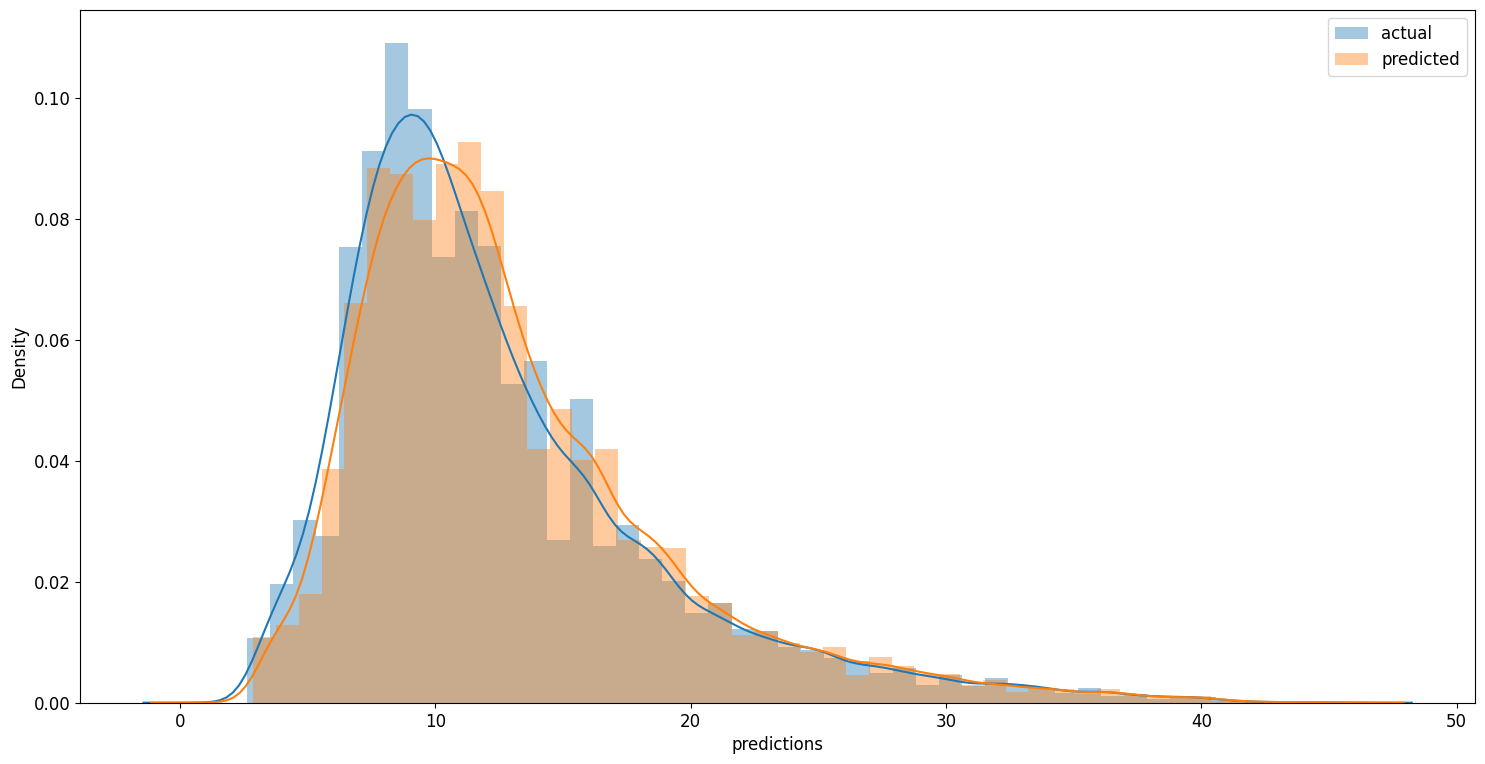

In [208]:
sns.distplot(df_results.loc[:, "total_amount"], label="actual");
sns.distplot(df_results.loc[:, "predictions"], label="predicted");
plt.legend();

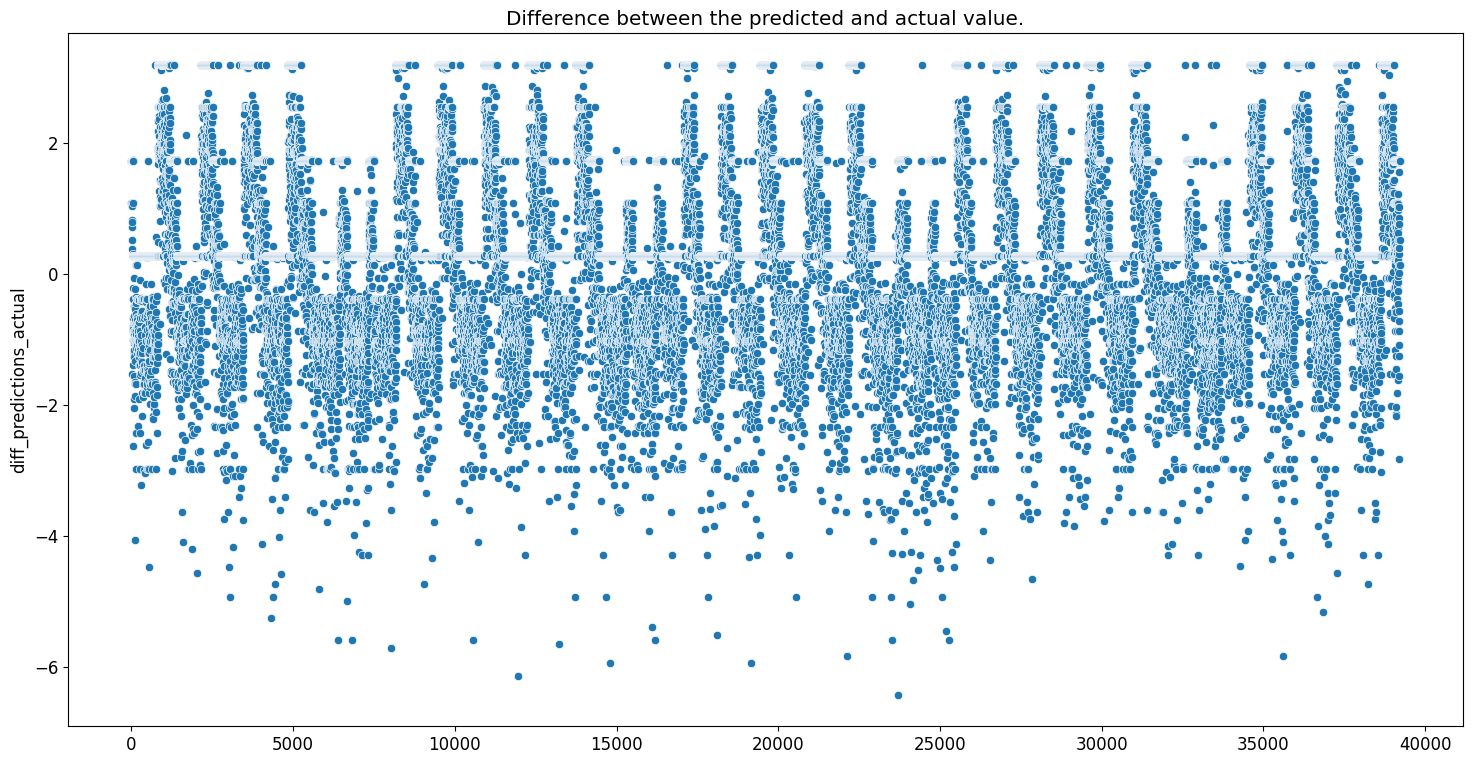

In [209]:
sns.scatterplot(df_results.loc[:, "diff_predictions_actual"]);
plt.title("Difference between the predicted and actual value.");

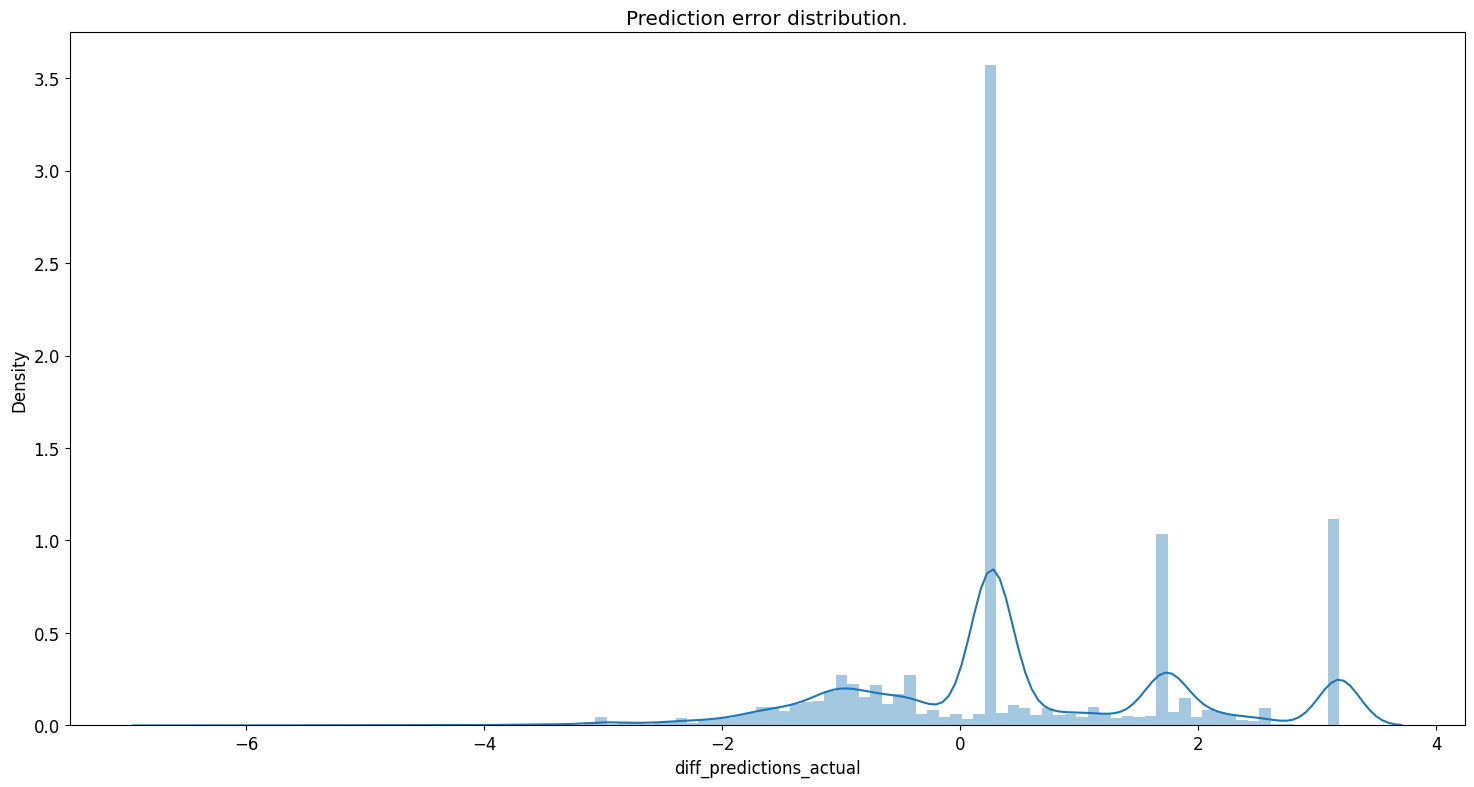

In [216]:
sns.distplot(df_results.loc[:,"diff_predictions_actual"], bins=100);
plt.title("Prediction error distribution.");

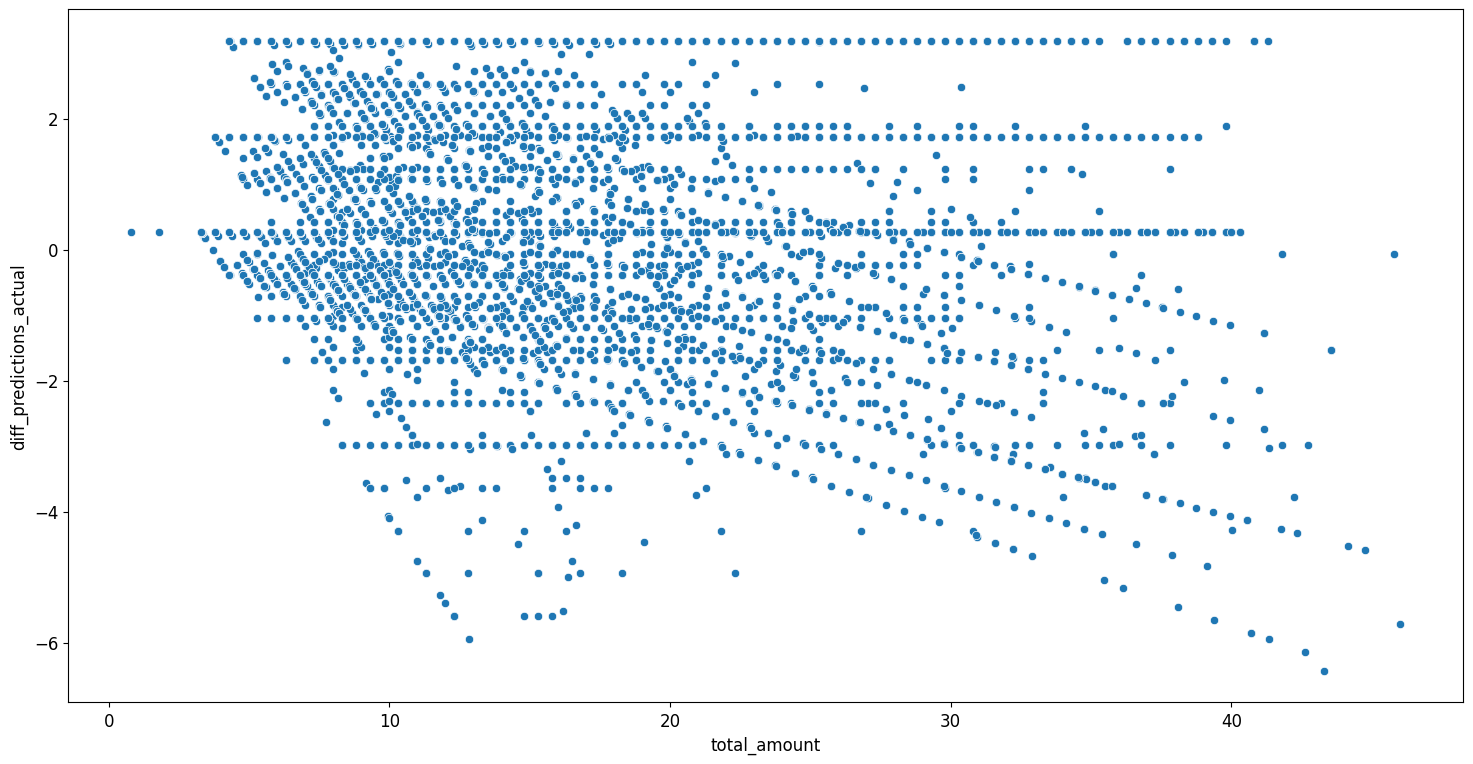

In [210]:
sns.scatterplot(x="total_amount", y="diff_predictions_actual", data=df_results);

In [211]:
# Since this model is the artifact of this notebook experiment,
# and its usage has just been tested and validated, now we can deploy this
# first version into production, and let it be handled by MLEngineers
# from now on.
mlflow_client.transition_model_version_stage(
    name=MODEL.model_name,
    version=MODEL.model_version,
    stage="Production",
    archive_existing_versions=True
)

<ModelVersion: creation_timestamp=1678291170100, current_stage='Production', description='', last_updated_timestamp=1678291297512, name='ridge-regressor', run_id='e0075f300f9d4ad1b491f1f2ae2877f9', run_link='', source='runs:/e0075f300f9d4ad1b491f1f2ae2877f9/models', status='READY', status_message='', tags={}, user_id='', version='1'>